In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 92)
(3944610, 8)
validation
(464344, 92)
(464344, 8)
test
(574820, 92)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 92)]              0         


 dense (Dense)               (None, 1024)              95232     


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 785288 (3.00 MB)


Trainable params: 785288 (3.00 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/395 [..............................] - ETA: 7:54 - loss: 2.2963 - STD: 0.0833 - MAE: 0.2185

  7/395 [..............................] - ETA: 3s - loss: 2.1228 - STD: 0.0548 - MAE: 0.2166  

 13/395 [..............................] - ETA: 3s - loss: 2.0992 - STD: 0.0465 - MAE: 0.2168

 19/395 [>.............................] - ETA: 3s - loss: 2.0867 - STD: 0.0432 - MAE: 0.2168

 25/395 [>.............................] - ETA: 3s - loss: 2.0789 - STD: 0.0407 - MAE: 0.2167

 31/395 [=>............................] - ETA: 3s - loss: 2.0740 - STD: 0.0394 - MAE: 0.2167

 38/395 [=>............................] - ETA: 3s - loss: 2.0697 - STD: 0.0381 - MAE: 0.2167

 45/395 [==>...........................] - ETA: 2s - loss: 2.0669 - STD: 0.0372 - MAE: 0.2167

 52/395 [==>...........................] - ETA: 2s - loss: 2.0646 - STD: 0.0365 - MAE: 0.2167

 58/395 [===>..........................] - ETA: 2s - loss: 2.0629 - STD: 0.0361 - MAE: 0.2167

 65/395 [===>..........................] - ETA: 2s - loss: 2.0611 - STD: 0.0356 - MAE: 0.2167

 72/395 [====>.........................] - ETA: 2s - loss: 2.0588 - STD: 0.0353 - MAE: 0.2166

 78/395 [====>.........................] - ETA: 2s - loss: 2.0563 - STD: 0.0353 - MAE: 0.2165

 84/395 [=====>........................] - ETA: 2s - loss: 2.0528 - STD: 0.0355 - MAE: 0.2164

 90/395 [=====>........................] - ETA: 2s - loss: 2.0485 - STD: 0.0363 - MAE: 0.2162

 96/395 [======>.......................] - ETA: 2s - loss: 2.0435 - STD: 0.0375 - MAE: 0.2159

102/395 [======>.......................] - ETA: 2s - loss: 2.0378 - STD: 0.0388 - MAE: 0.2156

109/395 [=======>......................] - ETA: 2s - loss: 2.0308 - STD: 0.0405 - MAE: 0.2152

116/395 [=======>......................] - ETA: 2s - loss: 2.0242 - STD: 0.0420 - MAE: 0.2149

123/395 [========>.....................] - ETA: 2s - loss: 2.0175 - STD: 0.0435 - MAE: 0.2145

129/395 [========>.....................] - ETA: 2s - loss: 2.0118 - STD: 0.0448 - MAE: 0.2142

135/395 [=========>....................] - ETA: 2s - loss: 2.0063 - STD: 0.0461 - MAE: 0.2138

141/395 [=========>....................] - ETA: 2s - loss: 2.0009 - STD: 0.0475 - MAE: 0.2135

148/395 [==========>...................] - ETA: 2s - loss: 1.9948 - STD: 0.0491 - MAE: 0.2131

155/395 [==========>...................] - ETA: 2s - loss: 1.9889 - STD: 0.0506 - MAE: 0.2127

162/395 [===========>..................] - ETA: 1s - loss: 1.9831 - STD: 0.0522 - MAE: 0.2123

169/395 [===========>..................] - ETA: 1s - loss: 1.9775 - STD: 0.0536 - MAE: 0.2119

176/395 [============>.................] - ETA: 1s - loss: 1.9720 - STD: 0.0550 - MAE: 0.2115

183/395 [============>.................] - ETA: 1s - loss: 1.9668 - STD: 0.0563 - MAE: 0.2112

190/395 [=============>................] - ETA: 1s - loss: 1.9618 - STD: 0.0576 - MAE: 0.2109

197/395 [=============>................] - ETA: 1s - loss: 1.9572 - STD: 0.0587 - MAE: 0.2106

204/395 [==============>...............] - ETA: 1s - loss: 1.9525 - STD: 0.0598 - MAE: 0.2103

207/395 [==============>...............] - ETA: 2s - loss: 1.9510 - STD: 0.0603 - MAE: 0.2101

214/395 [===============>..............] - ETA: 2s - loss: 1.9466 - STD: 0.0613 - MAE: 0.2098

221/395 [===============>..............] - ETA: 1s - loss: 1.9426 - STD: 0.0623 - MAE: 0.2096

228/395 [================>.............] - ETA: 1s - loss: 1.9388 - STD: 0.0632 - MAE: 0.2093

234/395 [================>.............] - ETA: 1s - loss: 1.9355 - STD: 0.0640 - MAE: 0.2091

241/395 [=================>............] - ETA: 1s - loss: 1.9320 - STD: 0.0648 - MAE: 0.2089

248/395 [=================>............] - ETA: 1s - loss: 1.9286 - STD: 0.0656 - MAE: 0.2087

255/395 [==================>...........] - ETA: 1s - loss: 1.9254 - STD: 0.0664 - MAE: 0.2084

261/395 [==================>...........] - ETA: 1s - loss: 1.9227 - STD: 0.0670 - MAE: 0.2083

268/395 [===================>..........] - ETA: 1s - loss: 1.9196 - STD: 0.0678 - MAE: 0.2081

275/395 [===================>..........] - ETA: 1s - loss: 1.9165 - STD: 0.0684 - MAE: 0.2079

281/395 [====================>.........] - ETA: 1s - loss: 1.9140 - STD: 0.0690 - MAE: 0.2077

288/395 [====================>.........] - ETA: 1s - loss: 1.9112 - STD: 0.0697 - MAE: 0.2075

295/395 [=====================>........] - ETA: 1s - loss: 1.9085 - STD: 0.0703 - MAE: 0.2073

302/395 [=====================>........] - ETA: 0s - loss: 1.9059 - STD: 0.0709 - MAE: 0.2072

309/395 [======================>.......] - ETA: 0s - loss: 1.9034 - STD: 0.0715 - MAE: 0.2070

315/395 [======================>.......] - ETA: 0s - loss: 1.9012 - STD: 0.0719 - MAE: 0.2069

322/395 [=======================>......] - ETA: 0s - loss: 1.8988 - STD: 0.0725 - MAE: 0.2067

329/395 [=======================>......] - ETA: 0s - loss: 1.8965 - STD: 0.0730 - MAE: 0.2066

335/395 [========================>.....] - ETA: 0s - loss: 1.8947 - STD: 0.0734 - MAE: 0.2064

342/395 [========================>.....] - ETA: 0s - loss: 1.8925 - STD: 0.0739 - MAE: 0.2063

348/395 [=========================>....] - ETA: 0s - loss: 1.8907 - STD: 0.0743 - MAE: 0.2062

355/395 [=========================>....] - ETA: 0s - loss: 1.8886 - STD: 0.0748 - MAE: 0.2060

361/395 [==========================>...] - ETA: 0s - loss: 1.8869 - STD: 0.0752 - MAE: 0.2059

368/395 [==========================>...] - ETA: 0s - loss: 1.8849 - STD: 0.0757 - MAE: 0.2058

374/395 [===========================>..] - ETA: 0s - loss: 1.8831 - STD: 0.0760 - MAE: 0.2057

380/395 [===========================>..] - ETA: 0s - loss: 1.8814 - STD: 0.0764 - MAE: 0.2056

387/395 [============================>.] - ETA: 0s - loss: 1.8796 - STD: 0.0768 - MAE: 0.2054

394/395 [============================>.] - ETA: 0s - loss: 1.8777 - STD: 0.0772 - MAE: 0.2053

395/395 [==============================] - 6s 12ms/step - loss: 1.8774 - STD: 0.0773 - MAE: 0.2053 - val_loss: 1.7682 - val_STD: 0.0977 - val_MAE: 0.1976


Epoch 2/10000


  1/395 [..............................] - ETA: 11s - loss: 1.7839 - STD: 0.0998 - MAE: 0.1988

  7/395 [..............................] - ETA: 3s - loss: 1.7760 - STD: 0.0995 - MAE: 0.1985 

 14/395 [>.............................] - ETA: 3s - loss: 1.7712 - STD: 0.1002 - MAE: 0.1982

 20/395 [>.............................] - ETA: 3s - loss: 1.7715 - STD: 0.1005 - MAE: 0.1982

 26/395 [>.............................] - ETA: 3s - loss: 1.7705 - STD: 0.1003 - MAE: 0.1982

 33/395 [=>............................] - ETA: 2s - loss: 1.7695 - STD: 0.1004 - MAE: 0.1982

 39/395 [=>............................] - ETA: 2s - loss: 1.7682 - STD: 0.1005 - MAE: 0.1981

 46/395 [==>...........................] - ETA: 2s - loss: 1.7674 - STD: 0.1007 - MAE: 0.1980

 52/395 [==>...........................] - ETA: 2s - loss: 1.7669 - STD: 0.1008 - MAE: 0.1980

 58/395 [===>..........................] - ETA: 2s - loss: 1.7661 - STD: 0.1009 - MAE: 0.1979

 65/395 [===>..........................] - ETA: 2s - loss: 1.7656 - STD: 0.1010 - MAE: 0.1979

 71/395 [====>.........................] - ETA: 2s - loss: 1.7645 - STD: 0.1012 - MAE: 0.1978

 78/395 [====>.........................] - ETA: 2s - loss: 1.7638 - STD: 0.1013 - MAE: 0.1978

 85/395 [=====>........................] - ETA: 2s - loss: 1.7631 - STD: 0.1013 - MAE: 0.1977

 92/395 [=====>........................] - ETA: 2s - loss: 1.7619 - STD: 0.1015 - MAE: 0.1976

 98/395 [======>.......................] - ETA: 2s - loss: 1.7608 - STD: 0.1017 - MAE: 0.1976

105/395 [======>.......................] - ETA: 2s - loss: 1.7600 - STD: 0.1018 - MAE: 0.1975

111/395 [=======>......................] - ETA: 2s - loss: 1.7592 - STD: 0.1019 - MAE: 0.1975

118/395 [=======>......................] - ETA: 2s - loss: 1.7582 - STD: 0.1021 - MAE: 0.1974

124/395 [========>.....................] - ETA: 2s - loss: 1.7574 - STD: 0.1022 - MAE: 0.1973

130/395 [========>.....................] - ETA: 2s - loss: 1.7565 - STD: 0.1024 - MAE: 0.1972

137/395 [=========>....................] - ETA: 2s - loss: 1.7557 - STD: 0.1025 - MAE: 0.1972

144/395 [=========>....................] - ETA: 2s - loss: 1.7548 - STD: 0.1027 - MAE: 0.1971

151/395 [==========>...................] - ETA: 2s - loss: 1.7538 - STD: 0.1029 - MAE: 0.1970

157/395 [==========>...................] - ETA: 1s - loss: 1.7528 - STD: 0.1030 - MAE: 0.1970

163/395 [===========>..................] - ETA: 1s - loss: 1.7521 - STD: 0.1032 - MAE: 0.1969

169/395 [===========>..................] - ETA: 1s - loss: 1.7514 - STD: 0.1033 - MAE: 0.1969

175/395 [============>.................] - ETA: 1s - loss: 1.7508 - STD: 0.1034 - MAE: 0.1968

182/395 [============>.................] - ETA: 1s - loss: 1.7496 - STD: 0.1036 - MAE: 0.1967

189/395 [=============>................] - ETA: 1s - loss: 1.7487 - STD: 0.1037 - MAE: 0.1967

195/395 [=============>................] - ETA: 1s - loss: 1.7479 - STD: 0.1039 - MAE: 0.1966

201/395 [==============>...............] - ETA: 1s - loss: 1.7473 - STD: 0.1040 - MAE: 0.1966

208/395 [==============>...............] - ETA: 1s - loss: 1.7465 - STD: 0.1041 - MAE: 0.1965

215/395 [===============>..............] - ETA: 1s - loss: 1.7455 - STD: 0.1042 - MAE: 0.1964

221/395 [===============>..............] - ETA: 1s - loss: 1.7448 - STD: 0.1044 - MAE: 0.1964

228/395 [================>.............] - ETA: 1s - loss: 1.7441 - STD: 0.1045 - MAE: 0.1963

234/395 [================>.............] - ETA: 1s - loss: 1.7433 - STD: 0.1046 - MAE: 0.1963

241/395 [=================>............] - ETA: 1s - loss: 1.7427 - STD: 0.1048 - MAE: 0.1962

247/395 [=================>............] - ETA: 1s - loss: 1.7420 - STD: 0.1049 - MAE: 0.1962

253/395 [==================>...........] - ETA: 1s - loss: 1.7413 - STD: 0.1050 - MAE: 0.1961

260/395 [==================>...........] - ETA: 1s - loss: 1.7406 - STD: 0.1052 - MAE: 0.1961

267/395 [===================>..........] - ETA: 1s - loss: 1.7397 - STD: 0.1052 - MAE: 0.1960

274/395 [===================>..........] - ETA: 1s - loss: 1.7389 - STD: 0.1054 - MAE: 0.1960

281/395 [====================>.........] - ETA: 0s - loss: 1.7382 - STD: 0.1055 - MAE: 0.1959

288/395 [====================>.........] - ETA: 0s - loss: 1.7373 - STD: 0.1056 - MAE: 0.1958

295/395 [=====================>........] - ETA: 0s - loss: 1.7364 - STD: 0.1058 - MAE: 0.1958

301/395 [=====================>........] - ETA: 0s - loss: 1.7356 - STD: 0.1059 - MAE: 0.1957

307/395 [======================>.......] - ETA: 0s - loss: 1.7349 - STD: 0.1060 - MAE: 0.1957

313/395 [======================>.......] - ETA: 0s - loss: 1.7341 - STD: 0.1061 - MAE: 0.1956

319/395 [=======================>......] - ETA: 0s - loss: 1.7332 - STD: 0.1062 - MAE: 0.1956

325/395 [=======================>......] - ETA: 0s - loss: 1.7330 - STD: 0.1064 - MAE: 0.1955

332/395 [========================>.....] - ETA: 0s - loss: 1.7327 - STD: 0.1065 - MAE: 0.1955

338/395 [========================>.....] - ETA: 0s - loss: 1.7323 - STD: 0.1067 - MAE: 0.1954

345/395 [=========================>....] - ETA: 0s - loss: 1.7317 - STD: 0.1068 - MAE: 0.1954

352/395 [=========================>....] - ETA: 0s - loss: 1.7310 - STD: 0.1068 - MAE: 0.1954

358/395 [==========================>...] - ETA: 0s - loss: 1.7303 - STD: 0.1069 - MAE: 0.1953

365/395 [==========================>...] - ETA: 0s - loss: 1.7295 - STD: 0.1070 - MAE: 0.1953

371/395 [===========================>..] - ETA: 0s - loss: 1.7288 - STD: 0.1071 - MAE: 0.1952

378/395 [===========================>..] - ETA: 0s - loss: 1.7280 - STD: 0.1072 - MAE: 0.1952

384/395 [============================>.] - ETA: 0s - loss: 1.7273 - STD: 0.1074 - MAE: 0.1951

390/395 [============================>.] - ETA: 0s - loss: 1.7267 - STD: 0.1075 - MAE: 0.1951

395/395 [==============================] - 4s 9ms/step - loss: 1.7262 - STD: 0.1075 - MAE: 0.1950 - val_loss: 1.6796 - val_STD: 0.1135 - val_MAE: 0.1905


Epoch 3/10000


  1/395 [..............................] - ETA: 10s - loss: 1.6777 - STD: 0.1152 - MAE: 0.1916

  8/395 [..............................] - ETA: 3s - loss: 1.6863 - STD: 0.1151 - MAE: 0.1919 

 14/395 [>.............................] - ETA: 3s - loss: 1.6827 - STD: 0.1148 - MAE: 0.1918

 21/395 [>.............................] - ETA: 3s - loss: 1.6808 - STD: 0.1146 - MAE: 0.1918

 27/395 [=>............................] - ETA: 3s - loss: 1.6800 - STD: 0.1148 - MAE: 0.1917

 33/395 [=>............................] - ETA: 3s - loss: 1.6793 - STD: 0.1150 - MAE: 0.1916

 39/395 [=>............................] - ETA: 2s - loss: 1.6798 - STD: 0.1150 - MAE: 0.1916

 45/395 [==>...........................] - ETA: 2s - loss: 1.6804 - STD: 0.1150 - MAE: 0.1917

 51/395 [==>...........................] - ETA: 2s - loss: 1.6804 - STD: 0.1151 - MAE: 0.1916

 57/395 [===>..........................] - ETA: 2s - loss: 1.6815 - STD: 0.1153 - MAE: 0.1916

 63/395 [===>..........................] - ETA: 2s - loss: 1.6814 - STD: 0.1153 - MAE: 0.1916

 69/395 [====>.........................] - ETA: 2s - loss: 1.6811 - STD: 0.1153 - MAE: 0.1916

 75/395 [====>.........................] - ETA: 2s - loss: 1.6805 - STD: 0.1153 - MAE: 0.1916

 81/395 [=====>........................] - ETA: 2s - loss: 1.6802 - STD: 0.1154 - MAE: 0.1916

 88/395 [=====>........................] - ETA: 2s - loss: 1.6800 - STD: 0.1155 - MAE: 0.1915

 94/395 [======>.......................] - ETA: 2s - loss: 1.6792 - STD: 0.1156 - MAE: 0.1915

100/395 [======>.......................] - ETA: 2s - loss: 1.6793 - STD: 0.1157 - MAE: 0.1915

106/395 [=======>......................] - ETA: 2s - loss: 1.6797 - STD: 0.1158 - MAE: 0.1914

113/395 [=======>......................] - ETA: 2s - loss: 1.6800 - STD: 0.1159 - MAE: 0.1914

119/395 [========>.....................] - ETA: 2s - loss: 1.6799 - STD: 0.1160 - MAE: 0.1914

125/395 [========>.....................] - ETA: 2s - loss: 1.6793 - STD: 0.1160 - MAE: 0.1914

132/395 [=========>....................] - ETA: 2s - loss: 1.6790 - STD: 0.1161 - MAE: 0.1914

138/395 [=========>....................] - ETA: 2s - loss: 1.6787 - STD: 0.1161 - MAE: 0.1913

144/395 [=========>....................] - ETA: 2s - loss: 1.6785 - STD: 0.1161 - MAE: 0.1913

150/395 [==========>...................] - ETA: 2s - loss: 1.6781 - STD: 0.1161 - MAE: 0.1913

156/395 [==========>...................] - ETA: 2s - loss: 1.6780 - STD: 0.1162 - MAE: 0.1913

162/395 [===========>..................] - ETA: 1s - loss: 1.6774 - STD: 0.1162 - MAE: 0.1912

169/395 [===========>..................] - ETA: 1s - loss: 1.6771 - STD: 0.1163 - MAE: 0.1912

176/395 [============>.................] - ETA: 1s - loss: 1.6766 - STD: 0.1164 - MAE: 0.1912

183/395 [============>.................] - ETA: 1s - loss: 1.6762 - STD: 0.1164 - MAE: 0.1912

190/395 [=============>................] - ETA: 1s - loss: 1.6759 - STD: 0.1165 - MAE: 0.1911

197/395 [=============>................] - ETA: 1s - loss: 1.6756 - STD: 0.1166 - MAE: 0.1911

203/395 [==============>...............] - ETA: 1s - loss: 1.6755 - STD: 0.1167 - MAE: 0.1911

209/395 [==============>...............] - ETA: 1s - loss: 1.6752 - STD: 0.1167 - MAE: 0.1911

216/395 [===============>..............] - ETA: 1s - loss: 1.6747 - STD: 0.1168 - MAE: 0.1910

223/395 [===============>..............] - ETA: 1s - loss: 1.6742 - STD: 0.1168 - MAE: 0.1910

229/395 [================>.............] - ETA: 1s - loss: 1.6739 - STD: 0.1169 - MAE: 0.1910

236/395 [================>.............] - ETA: 1s - loss: 1.6734 - STD: 0.1170 - MAE: 0.1909

242/395 [=================>............] - ETA: 1s - loss: 1.6732 - STD: 0.1170 - MAE: 0.1909

248/395 [=================>............] - ETA: 1s - loss: 1.6729 - STD: 0.1170 - MAE: 0.1909

255/395 [==================>...........] - ETA: 1s - loss: 1.6724 - STD: 0.1171 - MAE: 0.1908

261/395 [==================>...........] - ETA: 1s - loss: 1.6722 - STD: 0.1172 - MAE: 0.1908

267/395 [===================>..........] - ETA: 1s - loss: 1.6719 - STD: 0.1173 - MAE: 0.1908

273/395 [===================>..........] - ETA: 1s - loss: 1.6716 - STD: 0.1173 - MAE: 0.1908

280/395 [====================>.........] - ETA: 0s - loss: 1.6715 - STD: 0.1173 - MAE: 0.1908

286/395 [====================>.........] - ETA: 0s - loss: 1.6712 - STD: 0.1174 - MAE: 0.1907

292/395 [=====================>........] - ETA: 0s - loss: 1.6709 - STD: 0.1174 - MAE: 0.1907

298/395 [=====================>........] - ETA: 0s - loss: 1.6709 - STD: 0.1175 - MAE: 0.1907

305/395 [======================>.......] - ETA: 0s - loss: 1.6711 - STD: 0.1176 - MAE: 0.1907

312/395 [======================>.......] - ETA: 0s - loss: 1.6710 - STD: 0.1176 - MAE: 0.1907

319/395 [=======================>......] - ETA: 0s - loss: 1.6708 - STD: 0.1176 - MAE: 0.1907

326/395 [=======================>......] - ETA: 0s - loss: 1.6706 - STD: 0.1177 - MAE: 0.1906

333/395 [========================>.....] - ETA: 0s - loss: 1.6702 - STD: 0.1177 - MAE: 0.1906

340/395 [========================>.....] - ETA: 0s - loss: 1.6699 - STD: 0.1178 - MAE: 0.1906

346/395 [=========================>....] - ETA: 0s - loss: 1.6698 - STD: 0.1178 - MAE: 0.1906

353/395 [=========================>....] - ETA: 0s - loss: 1.6696 - STD: 0.1178 - MAE: 0.1906

360/395 [==========================>...] - ETA: 0s - loss: 1.6694 - STD: 0.1179 - MAE: 0.1905

367/395 [==========================>...] - ETA: 0s - loss: 1.6692 - STD: 0.1179 - MAE: 0.1905

374/395 [===========================>..] - ETA: 0s - loss: 1.6689 - STD: 0.1180 - MAE: 0.1905

381/395 [===========================>..] - ETA: 0s - loss: 1.6686 - STD: 0.1180 - MAE: 0.1905

387/395 [============================>.] - ETA: 0s - loss: 1.6684 - STD: 0.1181 - MAE: 0.1904

394/395 [============================>.] - ETA: 0s - loss: 1.6681 - STD: 0.1181 - MAE: 0.1904

395/395 [==============================] - 4s 9ms/step - loss: 1.6680 - STD: 0.1181 - MAE: 0.1904 - val_loss: 1.6288 - val_STD: 0.1166 - val_MAE: 0.1878


Epoch 4/10000


  1/395 [..............................] - ETA: 9s - loss: 1.6489 - STD: 0.1214 - MAE: 0.1887

  8/395 [..............................] - ETA: 3s - loss: 1.6480 - STD: 0.1212 - MAE: 0.1888

 15/395 [>.............................] - ETA: 3s - loss: 1.6486 - STD: 0.1212 - MAE: 0.1889

 22/395 [>.............................] - ETA: 3s - loss: 1.6505 - STD: 0.1211 - MAE: 0.1890

 29/395 [=>............................] - ETA: 3s - loss: 1.6491 - STD: 0.1211 - MAE: 0.1889

 36/395 [=>............................] - ETA: 2s - loss: 1.6494 - STD: 0.1210 - MAE: 0.1889

 42/395 [==>...........................] - ETA: 2s - loss: 1.6486 - STD: 0.1212 - MAE: 0.1889

 48/395 [==>...........................] - ETA: 2s - loss: 1.6485 - STD: 0.1214 - MAE: 0.1888

 55/395 [===>..........................] - ETA: 2s - loss: 1.6479 - STD: 0.1214 - MAE: 0.1888

 62/395 [===>..........................] - ETA: 2s - loss: 1.6478 - STD: 0.1214 - MAE: 0.1888

 69/395 [====>.........................] - ETA: 2s - loss: 1.6480 - STD: 0.1214 - MAE: 0.1888

 75/395 [====>.........................] - ETA: 2s - loss: 1.6479 - STD: 0.1216 - MAE: 0.1888

 81/395 [=====>........................] - ETA: 2s - loss: 1.6485 - STD: 0.1217 - MAE: 0.1888

 87/395 [=====>........................] - ETA: 2s - loss: 1.6486 - STD: 0.1217 - MAE: 0.1888

 93/395 [======>.......................] - ETA: 2s - loss: 1.6482 - STD: 0.1216 - MAE: 0.1888

100/395 [======>.......................] - ETA: 2s - loss: 1.6478 - STD: 0.1216 - MAE: 0.1887

107/395 [=======>......................] - ETA: 2s - loss: 1.6477 - STD: 0.1217 - MAE: 0.1887

114/395 [=======>......................] - ETA: 2s - loss: 1.6475 - STD: 0.1217 - MAE: 0.1887

121/395 [========>.....................] - ETA: 2s - loss: 1.6472 - STD: 0.1217 - MAE: 0.1887

127/395 [========>.....................] - ETA: 2s - loss: 1.6474 - STD: 0.1217 - MAE: 0.1887

134/395 [=========>....................] - ETA: 2s - loss: 1.6473 - STD: 0.1217 - MAE: 0.1887

140/395 [=========>....................] - ETA: 2s - loss: 1.6471 - STD: 0.1217 - MAE: 0.1887

147/395 [==========>...................] - ETA: 2s - loss: 1.6468 - STD: 0.1218 - MAE: 0.1887

153/395 [==========>...................] - ETA: 2s - loss: 1.6468 - STD: 0.1218 - MAE: 0.1887

160/395 [===========>..................] - ETA: 1s - loss: 1.6465 - STD: 0.1219 - MAE: 0.1886

167/395 [===========>..................] - ETA: 1s - loss: 1.6464 - STD: 0.1219 - MAE: 0.1886

174/395 [============>.................] - ETA: 1s - loss: 1.6464 - STD: 0.1219 - MAE: 0.1886

180/395 [============>.................] - ETA: 1s - loss: 1.6464 - STD: 0.1219 - MAE: 0.1886

186/395 [=============>................] - ETA: 1s - loss: 1.6463 - STD: 0.1219 - MAE: 0.1886

192/395 [=============>................] - ETA: 1s - loss: 1.6462 - STD: 0.1220 - MAE: 0.1886

199/395 [==============>...............] - ETA: 1s - loss: 1.6463 - STD: 0.1220 - MAE: 0.1886

206/395 [==============>...............] - ETA: 1s - loss: 1.6461 - STD: 0.1220 - MAE: 0.1886

213/395 [===============>..............] - ETA: 1s - loss: 1.6461 - STD: 0.1220 - MAE: 0.1886

219/395 [===============>..............] - ETA: 1s - loss: 1.6461 - STD: 0.1220 - MAE: 0.1886

225/395 [================>.............] - ETA: 1s - loss: 1.6460 - STD: 0.1220 - MAE: 0.1886

232/395 [================>.............] - ETA: 1s - loss: 1.6457 - STD: 0.1220 - MAE: 0.1886

239/395 [=================>............] - ETA: 1s - loss: 1.6456 - STD: 0.1221 - MAE: 0.1885

245/395 [=================>............] - ETA: 1s - loss: 1.6455 - STD: 0.1221 - MAE: 0.1885

252/395 [==================>...........] - ETA: 1s - loss: 1.6453 - STD: 0.1221 - MAE: 0.1885

259/395 [==================>...........] - ETA: 1s - loss: 1.6452 - STD: 0.1221 - MAE: 0.1885

265/395 [===================>..........] - ETA: 1s - loss: 1.6451 - STD: 0.1222 - MAE: 0.1885

272/395 [===================>..........] - ETA: 1s - loss: 1.6449 - STD: 0.1222 - MAE: 0.1885

279/395 [====================>.........] - ETA: 0s - loss: 1.6447 - STD: 0.1222 - MAE: 0.1885

286/395 [====================>.........] - ETA: 0s - loss: 1.6445 - STD: 0.1222 - MAE: 0.1885

292/395 [=====================>........] - ETA: 0s - loss: 1.6443 - STD: 0.1222 - MAE: 0.1885

299/395 [=====================>........] - ETA: 0s - loss: 1.6441 - STD: 0.1223 - MAE: 0.1884

306/395 [======================>.......] - ETA: 0s - loss: 1.6440 - STD: 0.1223 - MAE: 0.1884

312/395 [======================>.......] - ETA: 0s - loss: 1.6438 - STD: 0.1223 - MAE: 0.1884

319/395 [=======================>......] - ETA: 0s - loss: 1.6435 - STD: 0.1224 - MAE: 0.1884

325/395 [=======================>......] - ETA: 0s - loss: 1.6433 - STD: 0.1224 - MAE: 0.1884

332/395 [========================>.....] - ETA: 0s - loss: 1.6430 - STD: 0.1224 - MAE: 0.1884

338/395 [========================>.....] - ETA: 0s - loss: 1.6429 - STD: 0.1225 - MAE: 0.1883

345/395 [=========================>....] - ETA: 0s - loss: 1.6427 - STD: 0.1225 - MAE: 0.1883

352/395 [=========================>....] - ETA: 0s - loss: 1.6425 - STD: 0.1225 - MAE: 0.1883

358/395 [==========================>...] - ETA: 0s - loss: 1.6423 - STD: 0.1226 - MAE: 0.1883

364/395 [==========================>...] - ETA: 0s - loss: 1.6421 - STD: 0.1226 - MAE: 0.1883

371/395 [===========================>..] - ETA: 0s - loss: 1.6421 - STD: 0.1226 - MAE: 0.1883

377/395 [===========================>..] - ETA: 0s - loss: 1.6420 - STD: 0.1226 - MAE: 0.1883

384/395 [============================>.] - ETA: 0s - loss: 1.6418 - STD: 0.1227 - MAE: 0.1882

390/395 [============================>.] - ETA: 0s - loss: 1.6416 - STD: 0.1227 - MAE: 0.1882

395/395 [==============================] - 4s 9ms/step - loss: 1.6414 - STD: 0.1227 - MAE: 0.1882 - val_loss: 1.6090 - val_STD: 0.1191 - val_MAE: 0.1864


Epoch 5/10000


  1/395 [..............................] - ETA: 8s - loss: 1.6330 - STD: 0.1244 - MAE: 0.1876

  7/395 [..............................] - ETA: 3s - loss: 1.6289 - STD: 0.1241 - MAE: 0.1873

 14/395 [>.............................] - ETA: 3s - loss: 1.6313 - STD: 0.1243 - MAE: 0.1874

 21/395 [>.............................] - ETA: 3s - loss: 1.6301 - STD: 0.1242 - MAE: 0.1874

 28/395 [=>............................] - ETA: 3s - loss: 1.6304 - STD: 0.1242 - MAE: 0.1874

 34/395 [=>............................] - ETA: 2s - loss: 1.6303 - STD: 0.1243 - MAE: 0.1873

 41/395 [==>...........................] - ETA: 2s - loss: 1.6306 - STD: 0.1244 - MAE: 0.1873

 48/395 [==>...........................] - ETA: 2s - loss: 1.6314 - STD: 0.1244 - MAE: 0.1874

 54/395 [===>..........................] - ETA: 2s - loss: 1.6311 - STD: 0.1244 - MAE: 0.1873

 60/395 [===>..........................] - ETA: 2s - loss: 1.6315 - STD: 0.1244 - MAE: 0.1874

 66/395 [====>.........................] - ETA: 2s - loss: 1.6309 - STD: 0.1245 - MAE: 0.1873

 72/395 [====>.........................] - ETA: 2s - loss: 1.6311 - STD: 0.1245 - MAE: 0.1873

 78/395 [====>.........................] - ETA: 2s - loss: 1.6309 - STD: 0.1245 - MAE: 0.1873

 84/395 [=====>........................] - ETA: 2s - loss: 1.6305 - STD: 0.1245 - MAE: 0.1873

 91/395 [=====>........................] - ETA: 2s - loss: 1.6304 - STD: 0.1245 - MAE: 0.1873

 98/395 [======>.......................] - ETA: 2s - loss: 1.6306 - STD: 0.1246 - MAE: 0.1873

104/395 [======>.......................] - ETA: 2s - loss: 1.6305 - STD: 0.1246 - MAE: 0.1873

110/395 [=======>......................] - ETA: 2s - loss: 1.6302 - STD: 0.1246 - MAE: 0.1873

117/395 [=======>......................] - ETA: 2s - loss: 1.6310 - STD: 0.1247 - MAE: 0.1873

123/395 [========>.....................] - ETA: 2s - loss: 1.6313 - STD: 0.1247 - MAE: 0.1873

130/395 [========>.....................] - ETA: 2s - loss: 1.6312 - STD: 0.1247 - MAE: 0.1873

137/395 [=========>....................] - ETA: 2s - loss: 1.6309 - STD: 0.1246 - MAE: 0.1873

144/395 [=========>....................] - ETA: 2s - loss: 1.6306 - STD: 0.1246 - MAE: 0.1873

150/395 [==========>...................] - ETA: 2s - loss: 1.6303 - STD: 0.1246 - MAE: 0.1872

156/395 [==========>...................] - ETA: 1s - loss: 1.6300 - STD: 0.1247 - MAE: 0.1872

162/395 [===========>..................] - ETA: 1s - loss: 1.6299 - STD: 0.1247 - MAE: 0.1872

168/395 [===========>..................] - ETA: 1s - loss: 1.6297 - STD: 0.1248 - MAE: 0.1872

175/395 [============>.................] - ETA: 1s - loss: 1.6294 - STD: 0.1248 - MAE: 0.1872

182/395 [============>.................] - ETA: 1s - loss: 1.6291 - STD: 0.1248 - MAE: 0.1872

189/395 [=============>................] - ETA: 1s - loss: 1.6288 - STD: 0.1249 - MAE: 0.1871

196/395 [=============>................] - ETA: 1s - loss: 1.6287 - STD: 0.1250 - MAE: 0.1871

203/395 [==============>...............] - ETA: 1s - loss: 1.6283 - STD: 0.1250 - MAE: 0.1871

210/395 [==============>...............] - ETA: 1s - loss: 1.6283 - STD: 0.1250 - MAE: 0.1871

217/395 [===============>..............] - ETA: 1s - loss: 1.6281 - STD: 0.1250 - MAE: 0.1871

223/395 [===============>..............] - ETA: 1s - loss: 1.6280 - STD: 0.1251 - MAE: 0.1870

230/395 [================>.............] - ETA: 1s - loss: 1.6280 - STD: 0.1251 - MAE: 0.1870

237/395 [=================>............] - ETA: 1s - loss: 1.6282 - STD: 0.1251 - MAE: 0.1870

244/395 [=================>............] - ETA: 1s - loss: 1.6282 - STD: 0.1251 - MAE: 0.1870

250/395 [=================>............] - ETA: 1s - loss: 1.6282 - STD: 0.1251 - MAE: 0.1871

256/395 [==================>...........] - ETA: 1s - loss: 1.6282 - STD: 0.1251 - MAE: 0.1871

262/395 [==================>...........] - ETA: 1s - loss: 1.6282 - STD: 0.1251 - MAE: 0.1870

269/395 [===================>..........] - ETA: 1s - loss: 1.6280 - STD: 0.1251 - MAE: 0.1870

276/395 [===================>..........] - ETA: 0s - loss: 1.6278 - STD: 0.1251 - MAE: 0.1870

283/395 [====================>.........] - ETA: 0s - loss: 1.6275 - STD: 0.1251 - MAE: 0.1870

289/395 [====================>.........] - ETA: 0s - loss: 1.6273 - STD: 0.1252 - MAE: 0.1870

296/395 [=====================>........] - ETA: 0s - loss: 1.6271 - STD: 0.1252 - MAE: 0.1870

303/395 [======================>.......] - ETA: 0s - loss: 1.6268 - STD: 0.1252 - MAE: 0.1870

309/395 [======================>.......] - ETA: 0s - loss: 1.6267 - STD: 0.1252 - MAE: 0.1870

315/395 [======================>.......] - ETA: 0s - loss: 1.6266 - STD: 0.1252 - MAE: 0.1869

321/395 [=======================>......] - ETA: 0s - loss: 1.6265 - STD: 0.1253 - MAE: 0.1869

327/395 [=======================>......] - ETA: 0s - loss: 1.6264 - STD: 0.1253 - MAE: 0.1869

333/395 [========================>.....] - ETA: 0s - loss: 1.6261 - STD: 0.1253 - MAE: 0.1869

340/395 [========================>.....] - ETA: 0s - loss: 1.6259 - STD: 0.1254 - MAE: 0.1869

346/395 [=========================>....] - ETA: 0s - loss: 1.6258 - STD: 0.1254 - MAE: 0.1869

352/395 [=========================>....] - ETA: 0s - loss: 1.6257 - STD: 0.1254 - MAE: 0.1869

358/395 [==========================>...] - ETA: 0s - loss: 1.6256 - STD: 0.1254 - MAE: 0.1869

365/395 [==========================>...] - ETA: 0s - loss: 1.6254 - STD: 0.1254 - MAE: 0.1869

372/395 [===========================>..] - ETA: 0s - loss: 1.6252 - STD: 0.1255 - MAE: 0.1868

378/395 [===========================>..] - ETA: 0s - loss: 1.6251 - STD: 0.1255 - MAE: 0.1868

384/395 [============================>.] - ETA: 0s - loss: 1.6249 - STD: 0.1255 - MAE: 0.1868

391/395 [============================>.] - ETA: 0s - loss: 1.6247 - STD: 0.1255 - MAE: 0.1868

395/395 [==============================] - 4s 9ms/step - loss: 1.6246 - STD: 0.1255 - MAE: 0.1868 - val_loss: 1.6017 - val_STD: 0.1237 - val_MAE: 0.1847


Epoch 6/10000


  1/395 [..............................] - ETA: 9s - loss: 1.6088 - STD: 0.1300 - MAE: 0.1849

  7/395 [..............................] - ETA: 3s - loss: 1.6135 - STD: 0.1270 - MAE: 0.1859

 14/395 [>.............................] - ETA: 3s - loss: 1.6152 - STD: 0.1270 - MAE: 0.1860

 20/395 [>.............................] - ETA: 3s - loss: 1.6142 - STD: 0.1266 - MAE: 0.1861

 26/395 [>.............................] - ETA: 3s - loss: 1.6137 - STD: 0.1268 - MAE: 0.1860

 33/395 [=>............................] - ETA: 3s - loss: 1.6137 - STD: 0.1269 - MAE: 0.1860

 39/395 [=>............................] - ETA: 2s - loss: 1.6144 - STD: 0.1271 - MAE: 0.1860

 46/395 [==>...........................] - ETA: 2s - loss: 1.6162 - STD: 0.1270 - MAE: 0.1860

 53/395 [===>..........................] - ETA: 2s - loss: 1.6179 - STD: 0.1270 - MAE: 0.1861

 59/395 [===>..........................] - ETA: 2s - loss: 1.6182 - STD: 0.1269 - MAE: 0.1862

 66/395 [====>.........................] - ETA: 2s - loss: 1.6186 - STD: 0.1268 - MAE: 0.1862

 73/395 [====>.........................] - ETA: 2s - loss: 1.6185 - STD: 0.1267 - MAE: 0.1862

 80/395 [=====>........................] - ETA: 2s - loss: 1.6179 - STD: 0.1267 - MAE: 0.1862

 87/395 [=====>........................] - ETA: 2s - loss: 1.6175 - STD: 0.1268 - MAE: 0.1862

 94/395 [======>.......................] - ETA: 2s - loss: 1.6169 - STD: 0.1268 - MAE: 0.1862

100/395 [======>.......................] - ETA: 2s - loss: 1.6167 - STD: 0.1268 - MAE: 0.1861

106/395 [=======>......................] - ETA: 2s - loss: 1.6167 - STD: 0.1269 - MAE: 0.1861

113/395 [=======>......................] - ETA: 2s - loss: 1.6161 - STD: 0.1269 - MAE: 0.1861

120/395 [========>.....................] - ETA: 2s - loss: 1.6159 - STD: 0.1269 - MAE: 0.1861

127/395 [========>.....................] - ETA: 2s - loss: 1.6155 - STD: 0.1269 - MAE: 0.1861

134/395 [=========>....................] - ETA: 2s - loss: 1.6151 - STD: 0.1270 - MAE: 0.1860

140/395 [=========>....................] - ETA: 2s - loss: 1.6149 - STD: 0.1270 - MAE: 0.1860

146/395 [==========>...................] - ETA: 2s - loss: 1.6148 - STD: 0.1270 - MAE: 0.1860

152/395 [==========>...................] - ETA: 2s - loss: 1.6146 - STD: 0.1270 - MAE: 0.1860

158/395 [===========>..................] - ETA: 1s - loss: 1.6146 - STD: 0.1271 - MAE: 0.1860

164/395 [===========>..................] - ETA: 1s - loss: 1.6148 - STD: 0.1271 - MAE: 0.1860

171/395 [===========>..................] - ETA: 1s - loss: 1.6147 - STD: 0.1271 - MAE: 0.1860

178/395 [============>.................] - ETA: 1s - loss: 1.6145 - STD: 0.1271 - MAE: 0.1859

185/395 [=============>................] - ETA: 1s - loss: 1.6142 - STD: 0.1272 - MAE: 0.1859

192/395 [=============>................] - ETA: 1s - loss: 1.6138 - STD: 0.1272 - MAE: 0.1859

198/395 [==============>...............] - ETA: 1s - loss: 1.6137 - STD: 0.1272 - MAE: 0.1859

204/395 [==============>...............] - ETA: 1s - loss: 1.6133 - STD: 0.1272 - MAE: 0.1859

210/395 [==============>...............] - ETA: 1s - loss: 1.6131 - STD: 0.1273 - MAE: 0.1858

217/395 [===============>..............] - ETA: 1s - loss: 1.6129 - STD: 0.1273 - MAE: 0.1858

223/395 [===============>..............] - ETA: 1s - loss: 1.6127 - STD: 0.1273 - MAE: 0.1858

230/395 [================>.............] - ETA: 1s - loss: 1.6126 - STD: 0.1273 - MAE: 0.1858

237/395 [=================>............] - ETA: 1s - loss: 1.6124 - STD: 0.1273 - MAE: 0.1858

244/395 [=================>............] - ETA: 1s - loss: 1.6121 - STD: 0.1274 - MAE: 0.1858

251/395 [==================>...........] - ETA: 1s - loss: 1.6120 - STD: 0.1274 - MAE: 0.1858

258/395 [==================>...........] - ETA: 1s - loss: 1.6117 - STD: 0.1274 - MAE: 0.1858

265/395 [===================>..........] - ETA: 1s - loss: 1.6115 - STD: 0.1275 - MAE: 0.1857

272/395 [===================>..........] - ETA: 1s - loss: 1.6114 - STD: 0.1275 - MAE: 0.1857

279/395 [====================>.........] - ETA: 0s - loss: 1.6111 - STD: 0.1275 - MAE: 0.1857

285/395 [====================>.........] - ETA: 0s - loss: 1.6109 - STD: 0.1276 - MAE: 0.1857

292/395 [=====================>........] - ETA: 0s - loss: 1.6108 - STD: 0.1276 - MAE: 0.1857

299/395 [=====================>........] - ETA: 0s - loss: 1.6108 - STD: 0.1276 - MAE: 0.1857

306/395 [======================>.......] - ETA: 0s - loss: 1.6106 - STD: 0.1276 - MAE: 0.1857

313/395 [======================>.......] - ETA: 0s - loss: 1.6103 - STD: 0.1277 - MAE: 0.1856

320/395 [=======================>......] - ETA: 0s - loss: 1.6100 - STD: 0.1277 - MAE: 0.1856

327/395 [=======================>......] - ETA: 0s - loss: 1.6099 - STD: 0.1277 - MAE: 0.1856

334/395 [========================>.....] - ETA: 0s - loss: 1.6098 - STD: 0.1277 - MAE: 0.1856

341/395 [========================>.....] - ETA: 0s - loss: 1.6096 - STD: 0.1277 - MAE: 0.1856

348/395 [=========================>....] - ETA: 0s - loss: 1.6096 - STD: 0.1278 - MAE: 0.1856

355/395 [=========================>....] - ETA: 0s - loss: 1.6095 - STD: 0.1278 - MAE: 0.1856

362/395 [==========================>...] - ETA: 0s - loss: 1.6093 - STD: 0.1278 - MAE: 0.1856

369/395 [===========================>..] - ETA: 0s - loss: 1.6091 - STD: 0.1278 - MAE: 0.1855

376/395 [===========================>..] - ETA: 0s - loss: 1.6090 - STD: 0.1278 - MAE: 0.1855

383/395 [============================>.] - ETA: 0s - loss: 1.6089 - STD: 0.1279 - MAE: 0.1855

390/395 [============================>.] - ETA: 0s - loss: 1.6088 - STD: 0.1279 - MAE: 0.1855

395/395 [==============================] - 3s 9ms/step - loss: 1.6087 - STD: 0.1279 - MAE: 0.1855 - val_loss: 1.5856 - val_STD: 0.1223 - val_MAE: 0.1845


Epoch 7/10000


  1/395 [..............................] - ETA: 10s - loss: 1.5975 - STD: 0.1280 - MAE: 0.1849

  7/395 [..............................] - ETA: 3s - loss: 1.6026 - STD: 0.1289 - MAE: 0.1850 

 13/395 [..............................] - ETA: 3s - loss: 1.6044 - STD: 0.1291 - MAE: 0.1850

 20/395 [>.............................] - ETA: 3s - loss: 1.6045 - STD: 0.1291 - MAE: 0.1850

 26/395 [>.............................] - ETA: 3s - loss: 1.6042 - STD: 0.1289 - MAE: 0.1850

 33/395 [=>............................] - ETA: 3s - loss: 1.6035 - STD: 0.1288 - MAE: 0.1850

 39/395 [=>............................] - ETA: 2s - loss: 1.6018 - STD: 0.1289 - MAE: 0.1849

 45/395 [==>...........................] - ETA: 2s - loss: 1.6010 - STD: 0.1290 - MAE: 0.1849

 52/395 [==>...........................] - ETA: 2s - loss: 1.6003 - STD: 0.1291 - MAE: 0.1848

 59/395 [===>..........................] - ETA: 2s - loss: 1.6000 - STD: 0.1292 - MAE: 0.1848

 66/395 [====>.........................] - ETA: 2s - loss: 1.5999 - STD: 0.1292 - MAE: 0.1848

 73/395 [====>.........................] - ETA: 2s - loss: 1.5997 - STD: 0.1292 - MAE: 0.1847

 79/395 [=====>........................] - ETA: 2s - loss: 1.5988 - STD: 0.1293 - MAE: 0.1847

 85/395 [=====>........................] - ETA: 2s - loss: 1.5983 - STD: 0.1293 - MAE: 0.1847

 91/395 [=====>........................] - ETA: 2s - loss: 1.5983 - STD: 0.1294 - MAE: 0.1847

 97/395 [======>.......................] - ETA: 2s - loss: 1.5984 - STD: 0.1294 - MAE: 0.1846

103/395 [======>.......................] - ETA: 2s - loss: 1.5982 - STD: 0.1295 - MAE: 0.1846

110/395 [=======>......................] - ETA: 2s - loss: 1.5984 - STD: 0.1294 - MAE: 0.1847

117/395 [=======>......................] - ETA: 2s - loss: 1.5981 - STD: 0.1294 - MAE: 0.1846

124/395 [========>.....................] - ETA: 2s - loss: 1.5985 - STD: 0.1294 - MAE: 0.1847

130/395 [========>.....................] - ETA: 2s - loss: 1.5986 - STD: 0.1294 - MAE: 0.1847

137/395 [=========>....................] - ETA: 2s - loss: 1.5989 - STD: 0.1294 - MAE: 0.1847

144/395 [=========>....................] - ETA: 2s - loss: 1.5994 - STD: 0.1295 - MAE: 0.1847

151/395 [==========>...................] - ETA: 2s - loss: 1.5998 - STD: 0.1294 - MAE: 0.1847

157/395 [==========>...................] - ETA: 1s - loss: 1.5997 - STD: 0.1294 - MAE: 0.1847

164/395 [===========>..................] - ETA: 1s - loss: 1.5996 - STD: 0.1294 - MAE: 0.1847

171/395 [===========>..................] - ETA: 1s - loss: 1.5995 - STD: 0.1294 - MAE: 0.1847

177/395 [============>.................] - ETA: 1s - loss: 1.5993 - STD: 0.1294 - MAE: 0.1847

183/395 [============>.................] - ETA: 1s - loss: 1.5991 - STD: 0.1294 - MAE: 0.1847

189/395 [=============>................] - ETA: 1s - loss: 1.5989 - STD: 0.1295 - MAE: 0.1847

195/395 [=============>................] - ETA: 1s - loss: 1.5989 - STD: 0.1295 - MAE: 0.1847

201/395 [==============>...............] - ETA: 1s - loss: 1.5988 - STD: 0.1295 - MAE: 0.1847

207/395 [==============>...............] - ETA: 1s - loss: 1.5988 - STD: 0.1295 - MAE: 0.1846

214/395 [===============>..............] - ETA: 1s - loss: 1.5986 - STD: 0.1295 - MAE: 0.1846

221/395 [===============>..............] - ETA: 1s - loss: 1.5985 - STD: 0.1296 - MAE: 0.1846

228/395 [================>.............] - ETA: 1s - loss: 1.5983 - STD: 0.1296 - MAE: 0.1846

234/395 [================>.............] - ETA: 1s - loss: 1.5982 - STD: 0.1296 - MAE: 0.1846

240/395 [=================>............] - ETA: 1s - loss: 1.5978 - STD: 0.1297 - MAE: 0.1846

246/395 [=================>............] - ETA: 1s - loss: 1.5979 - STD: 0.1297 - MAE: 0.1846

253/395 [==================>...........] - ETA: 1s - loss: 1.5977 - STD: 0.1297 - MAE: 0.1845

260/395 [==================>...........] - ETA: 1s - loss: 1.5975 - STD: 0.1297 - MAE: 0.1845

267/395 [===================>..........] - ETA: 1s - loss: 1.5974 - STD: 0.1297 - MAE: 0.1845

274/395 [===================>..........] - ETA: 1s - loss: 1.5971 - STD: 0.1298 - MAE: 0.1845

281/395 [====================>.........] - ETA: 0s - loss: 1.5967 - STD: 0.1298 - MAE: 0.1845

287/395 [====================>.........] - ETA: 0s - loss: 1.5965 - STD: 0.1298 - MAE: 0.1845

293/395 [=====================>........] - ETA: 0s - loss: 1.5964 - STD: 0.1299 - MAE: 0.1845

299/395 [=====================>........] - ETA: 0s - loss: 1.5962 - STD: 0.1299 - MAE: 0.1844

306/395 [======================>.......] - ETA: 0s - loss: 1.5960 - STD: 0.1299 - MAE: 0.1844

313/395 [======================>.......] - ETA: 0s - loss: 1.5957 - STD: 0.1299 - MAE: 0.1844

320/395 [=======================>......] - ETA: 0s - loss: 1.5953 - STD: 0.1299 - MAE: 0.1844

327/395 [=======================>......] - ETA: 0s - loss: 1.5951 - STD: 0.1300 - MAE: 0.1844

334/395 [========================>.....] - ETA: 0s - loss: 1.5949 - STD: 0.1300 - MAE: 0.1843

341/395 [========================>.....] - ETA: 0s - loss: 1.5948 - STD: 0.1300 - MAE: 0.1843

348/395 [=========================>....] - ETA: 0s - loss: 1.5946 - STD: 0.1301 - MAE: 0.1843

354/395 [=========================>....] - ETA: 0s - loss: 1.5945 - STD: 0.1301 - MAE: 0.1843

361/395 [==========================>...] - ETA: 0s - loss: 1.5943 - STD: 0.1301 - MAE: 0.1843

368/395 [==========================>...] - ETA: 0s - loss: 1.5942 - STD: 0.1301 - MAE: 0.1843

374/395 [===========================>..] - ETA: 0s - loss: 1.5940 - STD: 0.1301 - MAE: 0.1843

380/395 [===========================>..] - ETA: 0s - loss: 1.5941 - STD: 0.1302 - MAE: 0.1843

387/395 [============================>.] - ETA: 0s - loss: 1.5940 - STD: 0.1302 - MAE: 0.1843

394/395 [============================>.] - ETA: 0s - loss: 1.5937 - STD: 0.1302 - MAE: 0.1843

395/395 [==============================] - 4s 9ms/step - loss: 1.5937 - STD: 0.1302 - MAE: 0.1843 - val_loss: 1.5767 - val_STD: 0.1249 - val_MAE: 0.1835


Epoch 8/10000


  1/395 [..............................] - ETA: 13s - loss: 1.5815 - STD: 0.1312 - MAE: 0.1834

  8/395 [..............................] - ETA: 3s - loss: 1.5810 - STD: 0.1319 - MAE: 0.1833 

 15/395 [>.............................] - ETA: 3s - loss: 1.5841 - STD: 0.1319 - MAE: 0.1833

 21/395 [>.............................] - ETA: 3s - loss: 1.5868 - STD: 0.1321 - MAE: 0.1834

 27/395 [=>............................] - ETA: 3s - loss: 1.5868 - STD: 0.1318 - MAE: 0.1835

 33/395 [=>............................] - ETA: 3s - loss: 1.5865 - STD: 0.1318 - MAE: 0.1835

 40/395 [==>...........................] - ETA: 2s - loss: 1.5863 - STD: 0.1318 - MAE: 0.1835

 47/395 [==>...........................] - ETA: 2s - loss: 1.5864 - STD: 0.1318 - MAE: 0.1835

 53/395 [===>..........................] - ETA: 2s - loss: 1.5861 - STD: 0.1316 - MAE: 0.1835

 60/395 [===>..........................] - ETA: 2s - loss: 1.5861 - STD: 0.1316 - MAE: 0.1835

 67/395 [====>.........................] - ETA: 2s - loss: 1.5861 - STD: 0.1318 - MAE: 0.1835

 74/395 [====>.........................] - ETA: 2s - loss: 1.5859 - STD: 0.1317 - MAE: 0.1835

 81/395 [=====>........................] - ETA: 2s - loss: 1.5860 - STD: 0.1317 - MAE: 0.1835

 88/395 [=====>........................] - ETA: 2s - loss: 1.5855 - STD: 0.1318 - MAE: 0.1835

 95/395 [======>.......................] - ETA: 2s - loss: 1.5852 - STD: 0.1317 - MAE: 0.1834

102/395 [======>.......................] - ETA: 2s - loss: 1.5845 - STD: 0.1317 - MAE: 0.1834

109/395 [=======>......................] - ETA: 2s - loss: 1.5840 - STD: 0.1317 - MAE: 0.1834

116/395 [=======>......................] - ETA: 2s - loss: 1.5837 - STD: 0.1318 - MAE: 0.1834

123/395 [========>.....................] - ETA: 2s - loss: 1.5837 - STD: 0.1318 - MAE: 0.1834

130/395 [========>.....................] - ETA: 2s - loss: 1.5836 - STD: 0.1319 - MAE: 0.1834

137/395 [=========>....................] - ETA: 2s - loss: 1.5832 - STD: 0.1319 - MAE: 0.1833

144/395 [=========>....................] - ETA: 2s - loss: 1.5831 - STD: 0.1319 - MAE: 0.1833

151/395 [==========>...................] - ETA: 2s - loss: 1.5833 - STD: 0.1320 - MAE: 0.1833

158/395 [===========>..................] - ETA: 1s - loss: 1.5831 - STD: 0.1320 - MAE: 0.1833

165/395 [===========>..................] - ETA: 1s - loss: 1.5830 - STD: 0.1320 - MAE: 0.1833

172/395 [============>.................] - ETA: 1s - loss: 1.5828 - STD: 0.1320 - MAE: 0.1833

179/395 [============>.................] - ETA: 1s - loss: 1.5829 - STD: 0.1320 - MAE: 0.1833

186/395 [=============>................] - ETA: 1s - loss: 1.5827 - STD: 0.1320 - MAE: 0.1833

192/395 [=============>................] - ETA: 1s - loss: 1.5826 - STD: 0.1320 - MAE: 0.1833

198/395 [==============>...............] - ETA: 1s - loss: 1.5826 - STD: 0.1321 - MAE: 0.1833

204/395 [==============>...............] - ETA: 1s - loss: 1.5825 - STD: 0.1321 - MAE: 0.1833

210/395 [==============>...............] - ETA: 1s - loss: 1.5823 - STD: 0.1321 - MAE: 0.1832

217/395 [===============>..............] - ETA: 1s - loss: 1.5823 - STD: 0.1321 - MAE: 0.1832

224/395 [================>.............] - ETA: 1s - loss: 1.5821 - STD: 0.1321 - MAE: 0.1832

231/395 [================>.............] - ETA: 1s - loss: 1.5819 - STD: 0.1321 - MAE: 0.1832

238/395 [=================>............] - ETA: 1s - loss: 1.5817 - STD: 0.1321 - MAE: 0.1832

245/395 [=================>............] - ETA: 1s - loss: 1.5815 - STD: 0.1322 - MAE: 0.1832

252/395 [==================>...........] - ETA: 1s - loss: 1.5814 - STD: 0.1322 - MAE: 0.1832

259/395 [==================>...........] - ETA: 1s - loss: 1.5812 - STD: 0.1322 - MAE: 0.1832

266/395 [===================>..........] - ETA: 1s - loss: 1.5811 - STD: 0.1322 - MAE: 0.1832

273/395 [===================>..........] - ETA: 0s - loss: 1.5810 - STD: 0.1322 - MAE: 0.1832

279/395 [====================>.........] - ETA: 0s - loss: 1.5810 - STD: 0.1322 - MAE: 0.1831

286/395 [====================>.........] - ETA: 0s - loss: 1.5809 - STD: 0.1323 - MAE: 0.1831

293/395 [=====================>........] - ETA: 0s - loss: 1.5809 - STD: 0.1323 - MAE: 0.1831

300/395 [=====================>........] - ETA: 0s - loss: 1.5810 - STD: 0.1323 - MAE: 0.1831

307/395 [======================>.......] - ETA: 0s - loss: 1.5810 - STD: 0.1323 - MAE: 0.1831

313/395 [======================>.......] - ETA: 0s - loss: 1.5810 - STD: 0.1323 - MAE: 0.1831

319/395 [=======================>......] - ETA: 0s - loss: 1.5809 - STD: 0.1323 - MAE: 0.1831

325/395 [=======================>......] - ETA: 0s - loss: 1.5809 - STD: 0.1323 - MAE: 0.1831

332/395 [========================>.....] - ETA: 0s - loss: 1.5806 - STD: 0.1323 - MAE: 0.1831

338/395 [========================>.....] - ETA: 0s - loss: 1.5804 - STD: 0.1324 - MAE: 0.1831

344/395 [=========================>....] - ETA: 0s - loss: 1.5803 - STD: 0.1324 - MAE: 0.1831

350/395 [=========================>....] - ETA: 0s - loss: 1.5802 - STD: 0.1324 - MAE: 0.1831

356/395 [==========================>...] - ETA: 0s - loss: 1.5801 - STD: 0.1324 - MAE: 0.1831

362/395 [==========================>...] - ETA: 0s - loss: 1.5800 - STD: 0.1324 - MAE: 0.1831

369/395 [===========================>..] - ETA: 0s - loss: 1.5798 - STD: 0.1325 - MAE: 0.1830

376/395 [===========================>..] - ETA: 0s - loss: 1.5798 - STD: 0.1325 - MAE: 0.1830

382/395 [============================>.] - ETA: 0s - loss: 1.5799 - STD: 0.1325 - MAE: 0.1830

389/395 [============================>.] - ETA: 0s - loss: 1.5800 - STD: 0.1325 - MAE: 0.1830

395/395 [==============================] - 3s 9ms/step - loss: 1.5798 - STD: 0.1325 - MAE: 0.1830 - val_loss: 1.5658 - val_STD: 0.1279 - val_MAE: 0.1822


Epoch 9/10000


  1/395 [..............................] - ETA: 9s - loss: 1.5687 - STD: 0.1339 - MAE: 0.1823

  8/395 [..............................] - ETA: 3s - loss: 1.5729 - STD: 0.1331 - MAE: 0.1827

 15/395 [>.............................] - ETA: 3s - loss: 1.5700 - STD: 0.1335 - MAE: 0.1824

 22/395 [>.............................] - ETA: 3s - loss: 1.5705 - STD: 0.1336 - MAE: 0.1823

 29/395 [=>............................] - ETA: 3s - loss: 1.5705 - STD: 0.1337 - MAE: 0.1823

 36/395 [=>............................] - ETA: 2s - loss: 1.5716 - STD: 0.1337 - MAE: 0.1824

 43/395 [==>...........................] - ETA: 2s - loss: 1.5709 - STD: 0.1336 - MAE: 0.1824

 50/395 [==>...........................] - ETA: 2s - loss: 1.5705 - STD: 0.1336 - MAE: 0.1823

 57/395 [===>..........................] - ETA: 2s - loss: 1.5702 - STD: 0.1336 - MAE: 0.1823

 63/395 [===>..........................] - ETA: 2s - loss: 1.5698 - STD: 0.1337 - MAE: 0.1823

 70/395 [====>.........................] - ETA: 2s - loss: 1.5701 - STD: 0.1338 - MAE: 0.1823

 76/395 [====>.........................] - ETA: 2s - loss: 1.5710 - STD: 0.1337 - MAE: 0.1823

 83/395 [=====>........................] - ETA: 2s - loss: 1.5717 - STD: 0.1338 - MAE: 0.1823

 90/395 [=====>........................] - ETA: 2s - loss: 1.5714 - STD: 0.1338 - MAE: 0.1823

 97/395 [======>.......................] - ETA: 2s - loss: 1.5722 - STD: 0.1339 - MAE: 0.1823

104/395 [======>.......................] - ETA: 2s - loss: 1.5719 - STD: 0.1338 - MAE: 0.1823

111/395 [=======>......................] - ETA: 2s - loss: 1.5716 - STD: 0.1338 - MAE: 0.1823

118/395 [=======>......................] - ETA: 2s - loss: 1.5712 - STD: 0.1338 - MAE: 0.1823

124/395 [========>.....................] - ETA: 2s - loss: 1.5708 - STD: 0.1338 - MAE: 0.1823

131/395 [========>.....................] - ETA: 2s - loss: 1.5705 - STD: 0.1339 - MAE: 0.1822

138/395 [=========>....................] - ETA: 2s - loss: 1.5702 - STD: 0.1339 - MAE: 0.1822

144/395 [=========>....................] - ETA: 2s - loss: 1.5698 - STD: 0.1340 - MAE: 0.1822

150/395 [==========>...................] - ETA: 2s - loss: 1.5697 - STD: 0.1340 - MAE: 0.1821

156/395 [==========>...................] - ETA: 1s - loss: 1.5697 - STD: 0.1341 - MAE: 0.1821

163/395 [===========>..................] - ETA: 1s - loss: 1.5695 - STD: 0.1341 - MAE: 0.1821

170/395 [===========>..................] - ETA: 1s - loss: 1.5693 - STD: 0.1341 - MAE: 0.1821

176/395 [============>.................] - ETA: 1s - loss: 1.5694 - STD: 0.1341 - MAE: 0.1821

183/395 [============>.................] - ETA: 1s - loss: 1.5695 - STD: 0.1341 - MAE: 0.1821

190/395 [=============>................] - ETA: 1s - loss: 1.5696 - STD: 0.1341 - MAE: 0.1821

197/395 [=============>................] - ETA: 1s - loss: 1.5696 - STD: 0.1341 - MAE: 0.1821

204/395 [==============>...............] - ETA: 1s - loss: 1.5691 - STD: 0.1342 - MAE: 0.1821

211/395 [===============>..............] - ETA: 1s - loss: 1.5692 - STD: 0.1342 - MAE: 0.1821

218/395 [===============>..............] - ETA: 1s - loss: 1.5689 - STD: 0.1342 - MAE: 0.1821

225/395 [================>.............] - ETA: 1s - loss: 1.5690 - STD: 0.1342 - MAE: 0.1821

232/395 [================>.............] - ETA: 1s - loss: 1.5688 - STD: 0.1343 - MAE: 0.1821

239/395 [=================>............] - ETA: 1s - loss: 1.5687 - STD: 0.1343 - MAE: 0.1820

246/395 [=================>............] - ETA: 1s - loss: 1.5686 - STD: 0.1343 - MAE: 0.1820

253/395 [==================>...........] - ETA: 1s - loss: 1.5684 - STD: 0.1343 - MAE: 0.1820

259/395 [==================>...........] - ETA: 1s - loss: 1.5681 - STD: 0.1344 - MAE: 0.1820

265/395 [===================>..........] - ETA: 1s - loss: 1.5679 - STD: 0.1344 - MAE: 0.1820

272/395 [===================>..........] - ETA: 1s - loss: 1.5677 - STD: 0.1344 - MAE: 0.1820

279/395 [====================>.........] - ETA: 0s - loss: 1.5675 - STD: 0.1344 - MAE: 0.1819

286/395 [====================>.........] - ETA: 0s - loss: 1.5674 - STD: 0.1345 - MAE: 0.1819

293/395 [=====================>........] - ETA: 0s - loss: 1.5674 - STD: 0.1345 - MAE: 0.1819

299/395 [=====================>........] - ETA: 0s - loss: 1.5674 - STD: 0.1345 - MAE: 0.1819

306/395 [======================>.......] - ETA: 0s - loss: 1.5673 - STD: 0.1345 - MAE: 0.1819

313/395 [======================>.......] - ETA: 0s - loss: 1.5671 - STD: 0.1345 - MAE: 0.1819

319/395 [=======================>......] - ETA: 0s - loss: 1.5669 - STD: 0.1346 - MAE: 0.1819

325/395 [=======================>......] - ETA: 0s - loss: 1.5670 - STD: 0.1346 - MAE: 0.1819

331/395 [========================>.....] - ETA: 0s - loss: 1.5669 - STD: 0.1346 - MAE: 0.1819

338/395 [========================>.....] - ETA: 0s - loss: 1.5669 - STD: 0.1346 - MAE: 0.1819

345/395 [=========================>....] - ETA: 0s - loss: 1.5667 - STD: 0.1346 - MAE: 0.1819

352/395 [=========================>....] - ETA: 0s - loss: 1.5665 - STD: 0.1346 - MAE: 0.1818

359/395 [==========================>...] - ETA: 0s - loss: 1.5664 - STD: 0.1347 - MAE: 0.1818

366/395 [==========================>...] - ETA: 0s - loss: 1.5662 - STD: 0.1347 - MAE: 0.1818

373/395 [===========================>..] - ETA: 0s - loss: 1.5662 - STD: 0.1347 - MAE: 0.1818

380/395 [===========================>..] - ETA: 0s - loss: 1.5662 - STD: 0.1347 - MAE: 0.1818

387/395 [============================>.] - ETA: 0s - loss: 1.5660 - STD: 0.1347 - MAE: 0.1818

393/395 [============================>.] - ETA: 0s - loss: 1.5659 - STD: 0.1348 - MAE: 0.1818

395/395 [==============================] - 3s 9ms/step - loss: 1.5659 - STD: 0.1348 - MAE: 0.1818 - val_loss: 1.5788 - val_STD: 0.1332 - val_MAE: 0.1812


Epoch 10/10000


  1/395 [..............................] - ETA: 10s - loss: 1.5689 - STD: 0.1388 - MAE: 0.1807

  8/395 [..............................] - ETA: 3s - loss: 1.5718 - STD: 0.1356 - MAE: 0.1818 

 15/395 [>.............................] - ETA: 3s - loss: 1.5798 - STD: 0.1356 - MAE: 0.1821

 22/395 [>.............................] - ETA: 3s - loss: 1.5774 - STD: 0.1353 - MAE: 0.1821

 29/395 [=>............................] - ETA: 2s - loss: 1.5736 - STD: 0.1351 - MAE: 0.1820

 36/395 [=>............................] - ETA: 2s - loss: 1.5707 - STD: 0.1352 - MAE: 0.1818

 43/395 [==>...........................] - ETA: 2s - loss: 1.5695 - STD: 0.1352 - MAE: 0.1818

 50/395 [==>...........................] - ETA: 2s - loss: 1.5679 - STD: 0.1353 - MAE: 0.1817

 57/395 [===>..........................] - ETA: 2s - loss: 1.5663 - STD: 0.1353 - MAE: 0.1816

 64/395 [===>..........................] - ETA: 2s - loss: 1.5651 - STD: 0.1355 - MAE: 0.1815

 71/395 [====>.........................] - ETA: 2s - loss: 1.5645 - STD: 0.1356 - MAE: 0.1815

 78/395 [====>.........................] - ETA: 2s - loss: 1.5641 - STD: 0.1356 - MAE: 0.1815

 85/395 [=====>........................] - ETA: 2s - loss: 1.5633 - STD: 0.1356 - MAE: 0.1815

 91/395 [=====>........................] - ETA: 2s - loss: 1.5626 - STD: 0.1356 - MAE: 0.1814

 98/395 [======>.......................] - ETA: 2s - loss: 1.5618 - STD: 0.1356 - MAE: 0.1814

104/395 [======>.......................] - ETA: 2s - loss: 1.5612 - STD: 0.1357 - MAE: 0.1813

111/395 [=======>......................] - ETA: 2s - loss: 1.5604 - STD: 0.1357 - MAE: 0.1813

118/395 [=======>......................] - ETA: 2s - loss: 1.5600 - STD: 0.1358 - MAE: 0.1812

124/395 [========>.....................] - ETA: 2s - loss: 1.5596 - STD: 0.1359 - MAE: 0.1812

131/395 [========>.....................] - ETA: 2s - loss: 1.5592 - STD: 0.1359 - MAE: 0.1812

137/395 [=========>....................] - ETA: 2s - loss: 1.5586 - STD: 0.1359 - MAE: 0.1811

143/395 [=========>....................] - ETA: 2s - loss: 1.5585 - STD: 0.1360 - MAE: 0.1811

149/395 [==========>...................] - ETA: 2s - loss: 1.5588 - STD: 0.1360 - MAE: 0.1811

156/395 [==========>...................] - ETA: 1s - loss: 1.5586 - STD: 0.1360 - MAE: 0.1811

162/395 [===========>..................] - ETA: 1s - loss: 1.5586 - STD: 0.1361 - MAE: 0.1811

169/395 [===========>..................] - ETA: 1s - loss: 1.5584 - STD: 0.1361 - MAE: 0.1811

175/395 [============>.................] - ETA: 1s - loss: 1.5582 - STD: 0.1361 - MAE: 0.1811

182/395 [============>.................] - ETA: 1s - loss: 1.5580 - STD: 0.1361 - MAE: 0.1811

189/395 [=============>................] - ETA: 1s - loss: 1.5579 - STD: 0.1362 - MAE: 0.1811

196/395 [=============>................] - ETA: 1s - loss: 1.5577 - STD: 0.1362 - MAE: 0.1810

203/395 [==============>...............] - ETA: 1s - loss: 1.5575 - STD: 0.1362 - MAE: 0.1810

210/395 [==============>...............] - ETA: 1s - loss: 1.5572 - STD: 0.1362 - MAE: 0.1810

217/395 [===============>..............] - ETA: 1s - loss: 1.5571 - STD: 0.1362 - MAE: 0.1810

224/395 [================>.............] - ETA: 1s - loss: 1.5570 - STD: 0.1362 - MAE: 0.1810

231/395 [================>.............] - ETA: 1s - loss: 1.5570 - STD: 0.1362 - MAE: 0.1810

238/395 [=================>............] - ETA: 1s - loss: 1.5568 - STD: 0.1362 - MAE: 0.1810

245/395 [=================>............] - ETA: 1s - loss: 1.5569 - STD: 0.1363 - MAE: 0.1810

251/395 [==================>...........] - ETA: 1s - loss: 1.5569 - STD: 0.1363 - MAE: 0.1810

257/395 [==================>...........] - ETA: 1s - loss: 1.5569 - STD: 0.1363 - MAE: 0.1810

264/395 [===================>..........] - ETA: 1s - loss: 1.5568 - STD: 0.1363 - MAE: 0.1810

271/395 [===================>..........] - ETA: 1s - loss: 1.5567 - STD: 0.1363 - MAE: 0.1810

278/395 [====================>.........] - ETA: 0s - loss: 1.5565 - STD: 0.1363 - MAE: 0.1810

284/395 [====================>.........] - ETA: 0s - loss: 1.5564 - STD: 0.1363 - MAE: 0.1809

290/395 [=====================>........] - ETA: 0s - loss: 1.5563 - STD: 0.1364 - MAE: 0.1809

296/395 [=====================>........] - ETA: 0s - loss: 1.5562 - STD: 0.1364 - MAE: 0.1809

303/395 [======================>.......] - ETA: 0s - loss: 1.5563 - STD: 0.1364 - MAE: 0.1809

309/395 [======================>.......] - ETA: 0s - loss: 1.5563 - STD: 0.1364 - MAE: 0.1809

315/395 [======================>.......] - ETA: 0s - loss: 1.5563 - STD: 0.1364 - MAE: 0.1809

321/395 [=======================>......] - ETA: 0s - loss: 1.5562 - STD: 0.1365 - MAE: 0.1809

327/395 [=======================>......] - ETA: 0s - loss: 1.5561 - STD: 0.1365 - MAE: 0.1809

334/395 [========================>.....] - ETA: 0s - loss: 1.5560 - STD: 0.1365 - MAE: 0.1809

341/395 [========================>.....] - ETA: 0s - loss: 1.5559 - STD: 0.1365 - MAE: 0.1809

348/395 [=========================>....] - ETA: 0s - loss: 1.5558 - STD: 0.1365 - MAE: 0.1809

355/395 [=========================>....] - ETA: 0s - loss: 1.5556 - STD: 0.1365 - MAE: 0.1809

362/395 [==========================>...] - ETA: 0s - loss: 1.5553 - STD: 0.1365 - MAE: 0.1808

369/395 [===========================>..] - ETA: 0s - loss: 1.5551 - STD: 0.1366 - MAE: 0.1808

376/395 [===========================>..] - ETA: 0s - loss: 1.5550 - STD: 0.1366 - MAE: 0.1808

383/395 [============================>.] - ETA: 0s - loss: 1.5549 - STD: 0.1366 - MAE: 0.1808

389/395 [============================>.] - ETA: 0s - loss: 1.5548 - STD: 0.1366 - MAE: 0.1808

395/395 [==============================] - 3s 9ms/step - loss: 1.5546 - STD: 0.1366 - MAE: 0.1808 - val_loss: 1.5632 - val_STD: 0.1329 - val_MAE: 0.1805


Epoch 11/10000


  1/395 [..............................] - ETA: 11s - loss: 1.5543 - STD: 0.1400 - MAE: 0.1798

  8/395 [..............................] - ETA: 3s - loss: 1.5425 - STD: 0.1379 - MAE: 0.1800 

 15/395 [>.............................] - ETA: 3s - loss: 1.5423 - STD: 0.1378 - MAE: 0.1800

 22/395 [>.............................] - ETA: 3s - loss: 1.5415 - STD: 0.1379 - MAE: 0.1799

 29/395 [=>............................] - ETA: 2s - loss: 1.5429 - STD: 0.1377 - MAE: 0.1800

 36/395 [=>............................] - ETA: 2s - loss: 1.5432 - STD: 0.1378 - MAE: 0.1800

 43/395 [==>...........................] - ETA: 2s - loss: 1.5440 - STD: 0.1379 - MAE: 0.1800

 50/395 [==>...........................] - ETA: 2s - loss: 1.5438 - STD: 0.1378 - MAE: 0.1800

 57/395 [===>..........................] - ETA: 2s - loss: 1.5447 - STD: 0.1378 - MAE: 0.1800

 64/395 [===>..........................] - ETA: 2s - loss: 1.5458 - STD: 0.1379 - MAE: 0.1801

 71/395 [====>.........................] - ETA: 2s - loss: 1.5462 - STD: 0.1379 - MAE: 0.1801

 77/395 [====>.........................] - ETA: 2s - loss: 1.5466 - STD: 0.1379 - MAE: 0.1801

 84/395 [=====>........................] - ETA: 2s - loss: 1.5465 - STD: 0.1379 - MAE: 0.1801

 91/395 [=====>........................] - ETA: 2s - loss: 1.5470 - STD: 0.1379 - MAE: 0.1801

 98/395 [======>.......................] - ETA: 2s - loss: 1.5473 - STD: 0.1379 - MAE: 0.1802

105/395 [======>.......................] - ETA: 2s - loss: 1.5478 - STD: 0.1378 - MAE: 0.1802

112/395 [=======>......................] - ETA: 2s - loss: 1.5477 - STD: 0.1378 - MAE: 0.1802

119/395 [========>.....................] - ETA: 2s - loss: 1.5474 - STD: 0.1378 - MAE: 0.1802

126/395 [========>.....................] - ETA: 2s - loss: 1.5468 - STD: 0.1378 - MAE: 0.1801

132/395 [=========>....................] - ETA: 2s - loss: 1.5467 - STD: 0.1379 - MAE: 0.1801

139/395 [=========>....................] - ETA: 2s - loss: 1.5468 - STD: 0.1379 - MAE: 0.1801

146/395 [==========>...................] - ETA: 2s - loss: 1.5467 - STD: 0.1379 - MAE: 0.1801

153/395 [==========>...................] - ETA: 1s - loss: 1.5465 - STD: 0.1379 - MAE: 0.1801

160/395 [===========>..................] - ETA: 1s - loss: 1.5463 - STD: 0.1379 - MAE: 0.1801

167/395 [===========>..................] - ETA: 1s - loss: 1.5459 - STD: 0.1380 - MAE: 0.1801

174/395 [============>.................] - ETA: 1s - loss: 1.5460 - STD: 0.1380 - MAE: 0.1800

181/395 [============>.................] - ETA: 1s - loss: 1.5460 - STD: 0.1380 - MAE: 0.1800

188/395 [=============>................] - ETA: 1s - loss: 1.5463 - STD: 0.1380 - MAE: 0.1801

195/395 [=============>................] - ETA: 1s - loss: 1.5463 - STD: 0.1380 - MAE: 0.1801

202/395 [==============>...............] - ETA: 1s - loss: 1.5462 - STD: 0.1380 - MAE: 0.1801

209/395 [==============>...............] - ETA: 1s - loss: 1.5459 - STD: 0.1380 - MAE: 0.1800

216/395 [===============>..............] - ETA: 1s - loss: 1.5455 - STD: 0.1380 - MAE: 0.1800

223/395 [===============>..............] - ETA: 1s - loss: 1.5454 - STD: 0.1381 - MAE: 0.1800

230/395 [================>.............] - ETA: 1s - loss: 1.5451 - STD: 0.1381 - MAE: 0.1800

237/395 [=================>............] - ETA: 1s - loss: 1.5448 - STD: 0.1381 - MAE: 0.1800

244/395 [=================>............] - ETA: 1s - loss: 1.5446 - STD: 0.1382 - MAE: 0.1799

251/395 [==================>...........] - ETA: 1s - loss: 1.5444 - STD: 0.1382 - MAE: 0.1799

257/395 [==================>...........] - ETA: 1s - loss: 1.5442 - STD: 0.1382 - MAE: 0.1799

264/395 [===================>..........] - ETA: 1s - loss: 1.5441 - STD: 0.1382 - MAE: 0.1799

271/395 [===================>..........] - ETA: 1s - loss: 1.5439 - STD: 0.1382 - MAE: 0.1799

278/395 [====================>.........] - ETA: 0s - loss: 1.5439 - STD: 0.1382 - MAE: 0.1799

285/395 [====================>.........] - ETA: 0s - loss: 1.5438 - STD: 0.1383 - MAE: 0.1799

292/395 [=====================>........] - ETA: 0s - loss: 1.5435 - STD: 0.1383 - MAE: 0.1799

299/395 [=====================>........] - ETA: 0s - loss: 1.5432 - STD: 0.1383 - MAE: 0.1798

306/395 [======================>.......] - ETA: 0s - loss: 1.5430 - STD: 0.1383 - MAE: 0.1798

313/395 [======================>.......] - ETA: 0s - loss: 1.5429 - STD: 0.1384 - MAE: 0.1798

319/395 [=======================>......] - ETA: 0s - loss: 1.5427 - STD: 0.1384 - MAE: 0.1798

326/395 [=======================>......] - ETA: 0s - loss: 1.5425 - STD: 0.1384 - MAE: 0.1798

333/395 [========================>.....] - ETA: 0s - loss: 1.5424 - STD: 0.1384 - MAE: 0.1798

339/395 [========================>.....] - ETA: 0s - loss: 1.5421 - STD: 0.1384 - MAE: 0.1798

346/395 [=========================>....] - ETA: 0s - loss: 1.5422 - STD: 0.1385 - MAE: 0.1797

353/395 [=========================>....] - ETA: 0s - loss: 1.5422 - STD: 0.1385 - MAE: 0.1797

360/395 [==========================>...] - ETA: 0s - loss: 1.5423 - STD: 0.1385 - MAE: 0.1798

367/395 [==========================>...] - ETA: 0s - loss: 1.5422 - STD: 0.1385 - MAE: 0.1797

373/395 [===========================>..] - ETA: 0s - loss: 1.5419 - STD: 0.1385 - MAE: 0.1797

379/395 [===========================>..] - ETA: 0s - loss: 1.5418 - STD: 0.1385 - MAE: 0.1797

385/395 [============================>.] - ETA: 0s - loss: 1.5417 - STD: 0.1385 - MAE: 0.1797

392/395 [============================>.] - ETA: 0s - loss: 1.5417 - STD: 0.1386 - MAE: 0.1797

395/395 [==============================] - 3s 9ms/step - loss: 1.5416 - STD: 0.1386 - MAE: 0.1797 - val_loss: 1.5535 - val_STD: 0.1317 - val_MAE: 0.1807


Epoch 12/10000


  1/395 [..............................] - ETA: 10s - loss: 1.5342 - STD: 0.1382 - MAE: 0.1796

  7/395 [..............................] - ETA: 3s - loss: 1.5297 - STD: 0.1397 - MAE: 0.1789 

 13/395 [..............................] - ETA: 3s - loss: 1.5303 - STD: 0.1400 - MAE: 0.1789

 19/395 [>.............................] - ETA: 3s - loss: 1.5317 - STD: 0.1396 - MAE: 0.1790

 26/395 [>.............................] - ETA: 3s - loss: 1.5326 - STD: 0.1396 - MAE: 0.1791

 33/395 [=>............................] - ETA: 3s - loss: 1.5322 - STD: 0.1395 - MAE: 0.1790

 40/395 [==>...........................] - ETA: 2s - loss: 1.5316 - STD: 0.1396 - MAE: 0.1790

 47/395 [==>...........................] - ETA: 2s - loss: 1.5320 - STD: 0.1397 - MAE: 0.1790

 54/395 [===>..........................] - ETA: 2s - loss: 1.5316 - STD: 0.1396 - MAE: 0.1790

 61/395 [===>..........................] - ETA: 2s - loss: 1.5315 - STD: 0.1398 - MAE: 0.1789

 68/395 [====>.........................] - ETA: 2s - loss: 1.5322 - STD: 0.1398 - MAE: 0.1789

 75/395 [====>.........................] - ETA: 2s - loss: 1.5333 - STD: 0.1397 - MAE: 0.1790

 81/395 [=====>........................] - ETA: 2s - loss: 1.5342 - STD: 0.1397 - MAE: 0.1791

 88/395 [=====>........................] - ETA: 2s - loss: 1.5349 - STD: 0.1396 - MAE: 0.1791

 95/395 [======>.......................] - ETA: 2s - loss: 1.5363 - STD: 0.1398 - MAE: 0.1791

101/395 [======>.......................] - ETA: 2s - loss: 1.5364 - STD: 0.1397 - MAE: 0.1792

108/395 [=======>......................] - ETA: 2s - loss: 1.5361 - STD: 0.1396 - MAE: 0.1791

115/395 [=======>......................] - ETA: 2s - loss: 1.5358 - STD: 0.1396 - MAE: 0.1791

121/395 [========>.....................] - ETA: 2s - loss: 1.5357 - STD: 0.1396 - MAE: 0.1791

128/395 [========>.....................] - ETA: 2s - loss: 1.5352 - STD: 0.1396 - MAE: 0.1791

134/395 [=========>....................] - ETA: 2s - loss: 1.5348 - STD: 0.1396 - MAE: 0.1791

141/395 [=========>....................] - ETA: 2s - loss: 1.5341 - STD: 0.1397 - MAE: 0.1790

147/395 [==========>...................] - ETA: 2s - loss: 1.5338 - STD: 0.1398 - MAE: 0.1790

153/395 [==========>...................] - ETA: 2s - loss: 1.5337 - STD: 0.1397 - MAE: 0.1790

160/395 [===========>..................] - ETA: 1s - loss: 1.5336 - STD: 0.1397 - MAE: 0.1790

166/395 [===========>..................] - ETA: 1s - loss: 1.5334 - STD: 0.1397 - MAE: 0.1790

172/395 [============>.................] - ETA: 1s - loss: 1.5333 - STD: 0.1397 - MAE: 0.1790

179/395 [============>.................] - ETA: 1s - loss: 1.5333 - STD: 0.1398 - MAE: 0.1790

185/395 [=============>................] - ETA: 1s - loss: 1.5332 - STD: 0.1398 - MAE: 0.1790

191/395 [=============>................] - ETA: 1s - loss: 1.5332 - STD: 0.1398 - MAE: 0.1790

197/395 [=============>................] - ETA: 1s - loss: 1.5331 - STD: 0.1398 - MAE: 0.1790

203/395 [==============>...............] - ETA: 1s - loss: 1.5330 - STD: 0.1398 - MAE: 0.1790

210/395 [==============>...............] - ETA: 1s - loss: 1.5329 - STD: 0.1399 - MAE: 0.1790

216/395 [===============>..............] - ETA: 1s - loss: 1.5327 - STD: 0.1399 - MAE: 0.1789

223/395 [===============>..............] - ETA: 1s - loss: 1.5327 - STD: 0.1399 - MAE: 0.1789

230/395 [================>.............] - ETA: 1s - loss: 1.5325 - STD: 0.1399 - MAE: 0.1789

237/395 [=================>............] - ETA: 1s - loss: 1.5325 - STD: 0.1399 - MAE: 0.1789

244/395 [=================>............] - ETA: 1s - loss: 1.5324 - STD: 0.1399 - MAE: 0.1789

251/395 [==================>...........] - ETA: 1s - loss: 1.5323 - STD: 0.1400 - MAE: 0.1789

258/395 [==================>...........] - ETA: 1s - loss: 1.5322 - STD: 0.1400 - MAE: 0.1789

265/395 [===================>..........] - ETA: 1s - loss: 1.5321 - STD: 0.1400 - MAE: 0.1789

271/395 [===================>..........] - ETA: 1s - loss: 1.5320 - STD: 0.1400 - MAE: 0.1789

278/395 [====================>.........] - ETA: 0s - loss: 1.5323 - STD: 0.1401 - MAE: 0.1789

285/395 [====================>.........] - ETA: 0s - loss: 1.5323 - STD: 0.1401 - MAE: 0.1789

292/395 [=====================>........] - ETA: 0s - loss: 1.5323 - STD: 0.1401 - MAE: 0.1789

299/395 [=====================>........] - ETA: 0s - loss: 1.5322 - STD: 0.1401 - MAE: 0.1789

306/395 [======================>.......] - ETA: 0s - loss: 1.5321 - STD: 0.1401 - MAE: 0.1789

312/395 [======================>.......] - ETA: 0s - loss: 1.5321 - STD: 0.1401 - MAE: 0.1789

319/395 [=======================>......] - ETA: 0s - loss: 1.5320 - STD: 0.1401 - MAE: 0.1789

326/395 [=======================>......] - ETA: 0s - loss: 1.5319 - STD: 0.1401 - MAE: 0.1789

332/395 [========================>.....] - ETA: 0s - loss: 1.5317 - STD: 0.1401 - MAE: 0.1788

338/395 [========================>.....] - ETA: 0s - loss: 1.5317 - STD: 0.1401 - MAE: 0.1788

345/395 [=========================>....] - ETA: 0s - loss: 1.5316 - STD: 0.1401 - MAE: 0.1788

351/395 [=========================>....] - ETA: 0s - loss: 1.5317 - STD: 0.1401 - MAE: 0.1788

357/395 [==========================>...] - ETA: 0s - loss: 1.5318 - STD: 0.1402 - MAE: 0.1788

363/395 [==========================>...] - ETA: 0s - loss: 1.5318 - STD: 0.1402 - MAE: 0.1788

370/395 [===========================>..] - ETA: 0s - loss: 1.5317 - STD: 0.1402 - MAE: 0.1788

376/395 [===========================>..] - ETA: 0s - loss: 1.5315 - STD: 0.1402 - MAE: 0.1788

382/395 [============================>.] - ETA: 0s - loss: 1.5314 - STD: 0.1402 - MAE: 0.1788

388/395 [============================>.] - ETA: 0s - loss: 1.5312 - STD: 0.1402 - MAE: 0.1788

395/395 [==============================] - ETA: 0s - loss: 1.5310 - STD: 0.1402 - MAE: 0.1788

395/395 [==============================] - 4s 9ms/step - loss: 1.5310 - STD: 0.1402 - MAE: 0.1788 - val_loss: 1.5499 - val_STD: 0.1346 - val_MAE: 0.1796


Epoch 13/10000


  1/395 [..............................] - ETA: 15s - loss: 1.5203 - STD: 0.1427 - MAE: 0.1776

  8/395 [..............................] - ETA: 3s - loss: 1.5153 - STD: 0.1415 - MAE: 0.1777 

 14/395 [>.............................] - ETA: 3s - loss: 1.5209 - STD: 0.1413 - MAE: 0.1780

 20/395 [>.............................] - ETA: 3s - loss: 1.5231 - STD: 0.1413 - MAE: 0.1782

 27/395 [=>............................] - ETA: 3s - loss: 1.5252 - STD: 0.1411 - MAE: 0.1783

 34/395 [=>............................] - ETA: 2s - loss: 1.5261 - STD: 0.1409 - MAE: 0.1784

 41/395 [==>...........................] - ETA: 2s - loss: 1.5260 - STD: 0.1409 - MAE: 0.1784

 47/395 [==>...........................] - ETA: 2s - loss: 1.5265 - STD: 0.1409 - MAE: 0.1784

 53/395 [===>..........................] - ETA: 2s - loss: 1.5255 - STD: 0.1408 - MAE: 0.1784

 59/395 [===>..........................] - ETA: 2s - loss: 1.5250 - STD: 0.1408 - MAE: 0.1784

 65/395 [===>..........................] - ETA: 2s - loss: 1.5250 - STD: 0.1408 - MAE: 0.1784

 71/395 [====>.........................] - ETA: 2s - loss: 1.5245 - STD: 0.1408 - MAE: 0.1783

 77/395 [====>.........................] - ETA: 2s - loss: 1.5241 - STD: 0.1408 - MAE: 0.1783

 83/395 [=====>........................] - ETA: 2s - loss: 1.5236 - STD: 0.1409 - MAE: 0.1783

 89/395 [=====>........................] - ETA: 2s - loss: 1.5231 - STD: 0.1410 - MAE: 0.1782

 95/395 [======>.......................] - ETA: 2s - loss: 1.5229 - STD: 0.1410 - MAE: 0.1782

101/395 [======>.......................] - ETA: 2s - loss: 1.5230 - STD: 0.1410 - MAE: 0.1782

107/395 [=======>......................] - ETA: 2s - loss: 1.5230 - STD: 0.1410 - MAE: 0.1782

113/395 [=======>......................] - ETA: 2s - loss: 1.5233 - STD: 0.1410 - MAE: 0.1782

119/395 [========>.....................] - ETA: 2s - loss: 1.5227 - STD: 0.1411 - MAE: 0.1782

125/395 [========>.....................] - ETA: 2s - loss: 1.5224 - STD: 0.1411 - MAE: 0.1782

131/395 [========>.....................] - ETA: 2s - loss: 1.5222 - STD: 0.1411 - MAE: 0.1782

137/395 [=========>....................] - ETA: 2s - loss: 1.5221 - STD: 0.1411 - MAE: 0.1782

143/395 [=========>....................] - ETA: 2s - loss: 1.5219 - STD: 0.1411 - MAE: 0.1781

149/395 [==========>...................] - ETA: 2s - loss: 1.5223 - STD: 0.1411 - MAE: 0.1782

155/395 [==========>...................] - ETA: 2s - loss: 1.5219 - STD: 0.1412 - MAE: 0.1781

161/395 [===========>..................] - ETA: 2s - loss: 1.5218 - STD: 0.1412 - MAE: 0.1781

167/395 [===========>..................] - ETA: 1s - loss: 1.5217 - STD: 0.1412 - MAE: 0.1781

173/395 [============>.................] - ETA: 1s - loss: 1.5217 - STD: 0.1412 - MAE: 0.1781

179/395 [============>.................] - ETA: 1s - loss: 1.5220 - STD: 0.1413 - MAE: 0.1781

185/395 [=============>................] - ETA: 1s - loss: 1.5220 - STD: 0.1413 - MAE: 0.1781

191/395 [=============>................] - ETA: 1s - loss: 1.5219 - STD: 0.1413 - MAE: 0.1781

197/395 [=============>................] - ETA: 1s - loss: 1.5216 - STD: 0.1413 - MAE: 0.1781

203/395 [==============>...............] - ETA: 1s - loss: 1.5215 - STD: 0.1413 - MAE: 0.1781

209/395 [==============>...............] - ETA: 1s - loss: 1.5216 - STD: 0.1413 - MAE: 0.1781

215/395 [===============>..............] - ETA: 1s - loss: 1.5213 - STD: 0.1413 - MAE: 0.1781

221/395 [===============>..............] - ETA: 1s - loss: 1.5211 - STD: 0.1413 - MAE: 0.1781

227/395 [================>.............] - ETA: 1s - loss: 1.5210 - STD: 0.1413 - MAE: 0.1780

233/395 [================>.............] - ETA: 1s - loss: 1.5207 - STD: 0.1414 - MAE: 0.1780

239/395 [=================>............] - ETA: 1s - loss: 1.5207 - STD: 0.1414 - MAE: 0.1780

245/395 [=================>............] - ETA: 1s - loss: 1.5207 - STD: 0.1414 - MAE: 0.1780

251/395 [==================>...........] - ETA: 1s - loss: 1.5207 - STD: 0.1414 - MAE: 0.1780

257/395 [==================>...........] - ETA: 1s - loss: 1.5205 - STD: 0.1414 - MAE: 0.1780

263/395 [==================>...........] - ETA: 1s - loss: 1.5204 - STD: 0.1414 - MAE: 0.1780

269/395 [===================>..........] - ETA: 1s - loss: 1.5202 - STD: 0.1414 - MAE: 0.1780

275/395 [===================>..........] - ETA: 1s - loss: 1.5201 - STD: 0.1415 - MAE: 0.1780

281/395 [====================>.........] - ETA: 0s - loss: 1.5200 - STD: 0.1415 - MAE: 0.1780

287/395 [====================>.........] - ETA: 0s - loss: 1.5199 - STD: 0.1415 - MAE: 0.1780

293/395 [=====================>........] - ETA: 0s - loss: 1.5199 - STD: 0.1415 - MAE: 0.1779

299/395 [=====================>........] - ETA: 0s - loss: 1.5198 - STD: 0.1415 - MAE: 0.1779

305/395 [======================>.......] - ETA: 0s - loss: 1.5199 - STD: 0.1415 - MAE: 0.1779

312/395 [======================>.......] - ETA: 0s - loss: 1.5200 - STD: 0.1416 - MAE: 0.1779

319/395 [=======================>......] - ETA: 0s - loss: 1.5200 - STD: 0.1416 - MAE: 0.1779

326/395 [=======================>......] - ETA: 0s - loss: 1.5198 - STD: 0.1416 - MAE: 0.1779

333/395 [========================>.....] - ETA: 0s - loss: 1.5196 - STD: 0.1416 - MAE: 0.1779

340/395 [========================>.....] - ETA: 0s - loss: 1.5193 - STD: 0.1416 - MAE: 0.1779

347/395 [=========================>....] - ETA: 0s - loss: 1.5193 - STD: 0.1417 - MAE: 0.1779

354/395 [=========================>....] - ETA: 0s - loss: 1.5191 - STD: 0.1417 - MAE: 0.1779

361/395 [==========================>...] - ETA: 0s - loss: 1.5190 - STD: 0.1417 - MAE: 0.1779

368/395 [==========================>...] - ETA: 0s - loss: 1.5187 - STD: 0.1417 - MAE: 0.1778

375/395 [===========================>..] - ETA: 0s - loss: 1.5187 - STD: 0.1418 - MAE: 0.1778

381/395 [===========================>..] - ETA: 0s - loss: 1.5186 - STD: 0.1418 - MAE: 0.1778

387/395 [============================>.] - ETA: 0s - loss: 1.5185 - STD: 0.1418 - MAE: 0.1778

393/395 [============================>.] - ETA: 0s - loss: 1.5183 - STD: 0.1418 - MAE: 0.1778

395/395 [==============================] - 4s 9ms/step - loss: 1.5183 - STD: 0.1418 - MAE: 0.1778 - val_loss: 1.5547 - val_STD: 0.1355 - val_MAE: 0.1798


Epoch 14/10000


  1/395 [..............................] - ETA: 9s - loss: 1.5305 - STD: 0.1417 - MAE: 0.1786

  8/395 [..............................] - ETA: 3s - loss: 1.5156 - STD: 0.1424 - MAE: 0.1775

 14/395 [>.............................] - ETA: 3s - loss: 1.5118 - STD: 0.1429 - MAE: 0.1771

 20/395 [>.............................] - ETA: 3s - loss: 1.5107 - STD: 0.1429 - MAE: 0.1771

 26/395 [>.............................] - ETA: 3s - loss: 1.5143 - STD: 0.1429 - MAE: 0.1773

 33/395 [=>............................] - ETA: 3s - loss: 1.5146 - STD: 0.1429 - MAE: 0.1773

 39/395 [=>............................] - ETA: 2s - loss: 1.5142 - STD: 0.1429 - MAE: 0.1773

 45/395 [==>...........................] - ETA: 2s - loss: 1.5136 - STD: 0.1429 - MAE: 0.1773

 51/395 [==>...........................] - ETA: 2s - loss: 1.5138 - STD: 0.1427 - MAE: 0.1773

 57/395 [===>..........................] - ETA: 2s - loss: 1.5131 - STD: 0.1427 - MAE: 0.1773

 64/395 [===>..........................] - ETA: 2s - loss: 1.5129 - STD: 0.1427 - MAE: 0.1773

 70/395 [====>.........................] - ETA: 2s - loss: 1.5139 - STD: 0.1428 - MAE: 0.1773

 77/395 [====>.........................] - ETA: 2s - loss: 1.5138 - STD: 0.1428 - MAE: 0.1773

 83/395 [=====>........................] - ETA: 2s - loss: 1.5137 - STD: 0.1429 - MAE: 0.1773

 90/395 [=====>........................] - ETA: 2s - loss: 1.5137 - STD: 0.1429 - MAE: 0.1773

 97/395 [======>.......................] - ETA: 2s - loss: 1.5136 - STD: 0.1429 - MAE: 0.1773

104/395 [======>.......................] - ETA: 2s - loss: 1.5141 - STD: 0.1428 - MAE: 0.1773

111/395 [=======>......................] - ETA: 2s - loss: 1.5142 - STD: 0.1428 - MAE: 0.1773

118/395 [=======>......................] - ETA: 2s - loss: 1.5139 - STD: 0.1428 - MAE: 0.1773

124/395 [========>.....................] - ETA: 2s - loss: 1.5134 - STD: 0.1428 - MAE: 0.1773

131/395 [========>.....................] - ETA: 2s - loss: 1.5128 - STD: 0.1429 - MAE: 0.1773

138/395 [=========>....................] - ETA: 2s - loss: 1.5124 - STD: 0.1429 - MAE: 0.1772

145/395 [==========>...................] - ETA: 2s - loss: 1.5120 - STD: 0.1429 - MAE: 0.1772

152/395 [==========>...................] - ETA: 1s - loss: 1.5116 - STD: 0.1429 - MAE: 0.1772

159/395 [===========>..................] - ETA: 1s - loss: 1.5117 - STD: 0.1430 - MAE: 0.1772

165/395 [===========>..................] - ETA: 1s - loss: 1.5118 - STD: 0.1430 - MAE: 0.1772

172/395 [============>.................] - ETA: 1s - loss: 1.5116 - STD: 0.1430 - MAE: 0.1772

179/395 [============>.................] - ETA: 1s - loss: 1.5114 - STD: 0.1430 - MAE: 0.1772

186/395 [=============>................] - ETA: 1s - loss: 1.5109 - STD: 0.1430 - MAE: 0.1771

192/395 [=============>................] - ETA: 1s - loss: 1.5108 - STD: 0.1430 - MAE: 0.1771

198/395 [==============>...............] - ETA: 1s - loss: 1.5108 - STD: 0.1430 - MAE: 0.1771

204/395 [==============>...............] - ETA: 1s - loss: 1.5107 - STD: 0.1431 - MAE: 0.1771

210/395 [==============>...............] - ETA: 1s - loss: 1.5108 - STD: 0.1431 - MAE: 0.1771

217/395 [===============>..............] - ETA: 1s - loss: 1.5108 - STD: 0.1430 - MAE: 0.1771

223/395 [===============>..............] - ETA: 1s - loss: 1.5107 - STD: 0.1430 - MAE: 0.1771

229/395 [================>.............] - ETA: 1s - loss: 1.5108 - STD: 0.1431 - MAE: 0.1771

235/395 [================>.............] - ETA: 1s - loss: 1.5107 - STD: 0.1431 - MAE: 0.1771

242/395 [=================>............] - ETA: 1s - loss: 1.5105 - STD: 0.1430 - MAE: 0.1771

248/395 [=================>............] - ETA: 1s - loss: 1.5104 - STD: 0.1431 - MAE: 0.1771

254/395 [==================>...........] - ETA: 1s - loss: 1.5104 - STD: 0.1431 - MAE: 0.1771

260/395 [==================>...........] - ETA: 1s - loss: 1.5104 - STD: 0.1431 - MAE: 0.1771

266/395 [===================>..........] - ETA: 1s - loss: 1.5103 - STD: 0.1431 - MAE: 0.1771

273/395 [===================>..........] - ETA: 1s - loss: 1.5103 - STD: 0.1431 - MAE: 0.1771

279/395 [====================>.........] - ETA: 0s - loss: 1.5103 - STD: 0.1431 - MAE: 0.1771

285/395 [====================>.........] - ETA: 0s - loss: 1.5103 - STD: 0.1432 - MAE: 0.1771

291/395 [=====================>........] - ETA: 0s - loss: 1.5102 - STD: 0.1432 - MAE: 0.1771

297/395 [=====================>........] - ETA: 0s - loss: 1.5102 - STD: 0.1432 - MAE: 0.1771

303/395 [======================>.......] - ETA: 0s - loss: 1.5100 - STD: 0.1432 - MAE: 0.1771

309/395 [======================>.......] - ETA: 0s - loss: 1.5098 - STD: 0.1432 - MAE: 0.1771

315/395 [======================>.......] - ETA: 0s - loss: 1.5100 - STD: 0.1432 - MAE: 0.1771

321/395 [=======================>......] - ETA: 0s - loss: 1.5099 - STD: 0.1432 - MAE: 0.1771

327/395 [=======================>......] - ETA: 0s - loss: 1.5101 - STD: 0.1432 - MAE: 0.1770

333/395 [========================>.....] - ETA: 0s - loss: 1.5100 - STD: 0.1432 - MAE: 0.1770

339/395 [========================>.....] - ETA: 0s - loss: 1.5101 - STD: 0.1432 - MAE: 0.1770

345/395 [=========================>....] - ETA: 0s - loss: 1.5100 - STD: 0.1432 - MAE: 0.1770

351/395 [=========================>....] - ETA: 0s - loss: 1.5100 - STD: 0.1432 - MAE: 0.1770

357/395 [==========================>...] - ETA: 0s - loss: 1.5097 - STD: 0.1432 - MAE: 0.1770

363/395 [==========================>...] - ETA: 0s - loss: 1.5095 - STD: 0.1432 - MAE: 0.1770

369/395 [===========================>..] - ETA: 0s - loss: 1.5092 - STD: 0.1432 - MAE: 0.1770

375/395 [===========================>..] - ETA: 0s - loss: 1.5091 - STD: 0.1433 - MAE: 0.1770

381/395 [===========================>..] - ETA: 0s - loss: 1.5090 - STD: 0.1433 - MAE: 0.1770

387/395 [============================>.] - ETA: 0s - loss: 1.5089 - STD: 0.1433 - MAE: 0.1770

393/395 [============================>.] - ETA: 0s - loss: 1.5088 - STD: 0.1433 - MAE: 0.1770

395/395 [==============================] - 4s 9ms/step - loss: 1.5088 - STD: 0.1433 - MAE: 0.1770 - val_loss: 1.5503 - val_STD: 0.1338 - val_MAE: 0.1800


Epoch 15/10000


  1/395 [..............................] - ETA: 9s - loss: 1.4974 - STD: 0.1413 - MAE: 0.1770

  7/395 [..............................] - ETA: 3s - loss: 1.5045 - STD: 0.1439 - MAE: 0.1765

 13/395 [..............................] - ETA: 3s - loss: 1.4990 - STD: 0.1441 - MAE: 0.1763

 19/395 [>.............................] - ETA: 3s - loss: 1.4975 - STD: 0.1441 - MAE: 0.1762

 26/395 [>.............................] - ETA: 3s - loss: 1.4984 - STD: 0.1441 - MAE: 0.1763

 32/395 [=>............................] - ETA: 3s - loss: 1.4987 - STD: 0.1443 - MAE: 0.1762

 38/395 [=>............................] - ETA: 3s - loss: 1.5009 - STD: 0.1444 - MAE: 0.1763

 44/395 [==>...........................] - ETA: 2s - loss: 1.5033 - STD: 0.1445 - MAE: 0.1764

 50/395 [==>...........................] - ETA: 2s - loss: 1.5050 - STD: 0.1445 - MAE: 0.1765

 57/395 [===>..........................] - ETA: 2s - loss: 1.5057 - STD: 0.1445 - MAE: 0.1765

 63/395 [===>..........................] - ETA: 2s - loss: 1.5083 - STD: 0.1445 - MAE: 0.1766

 69/395 [====>.........................] - ETA: 2s - loss: 1.5090 - STD: 0.1444 - MAE: 0.1767

 75/395 [====>.........................] - ETA: 2s - loss: 1.5092 - STD: 0.1442 - MAE: 0.1767

 81/395 [=====>........................] - ETA: 2s - loss: 1.5092 - STD: 0.1441 - MAE: 0.1768

 87/395 [=====>........................] - ETA: 2s - loss: 1.5088 - STD: 0.1441 - MAE: 0.1767

 93/395 [======>.......................] - ETA: 2s - loss: 1.5081 - STD: 0.1440 - MAE: 0.1767

 99/395 [======>.......................] - ETA: 2s - loss: 1.5078 - STD: 0.1440 - MAE: 0.1767

105/395 [======>.......................] - ETA: 2s - loss: 1.5075 - STD: 0.1441 - MAE: 0.1767

111/395 [=======>......................] - ETA: 2s - loss: 1.5070 - STD: 0.1440 - MAE: 0.1767

117/395 [=======>......................] - ETA: 2s - loss: 1.5068 - STD: 0.1440 - MAE: 0.1767

123/395 [========>.....................] - ETA: 2s - loss: 1.5065 - STD: 0.1440 - MAE: 0.1766

130/395 [========>.....................] - ETA: 2s - loss: 1.5061 - STD: 0.1440 - MAE: 0.1766

137/395 [=========>....................] - ETA: 2s - loss: 1.5059 - STD: 0.1440 - MAE: 0.1766

144/395 [=========>....................] - ETA: 2s - loss: 1.5057 - STD: 0.1440 - MAE: 0.1766

151/395 [==========>...................] - ETA: 2s - loss: 1.5056 - STD: 0.1440 - MAE: 0.1766

158/395 [===========>..................] - ETA: 1s - loss: 1.5052 - STD: 0.1440 - MAE: 0.1766

164/395 [===========>..................] - ETA: 1s - loss: 1.5048 - STD: 0.1440 - MAE: 0.1766

171/395 [===========>..................] - ETA: 1s - loss: 1.5045 - STD: 0.1441 - MAE: 0.1766

178/395 [============>.................] - ETA: 1s - loss: 1.5045 - STD: 0.1441 - MAE: 0.1766

185/395 [=============>................] - ETA: 1s - loss: 1.5043 - STD: 0.1441 - MAE: 0.1765

192/395 [=============>................] - ETA: 1s - loss: 1.5043 - STD: 0.1441 - MAE: 0.1765

199/395 [==============>...............] - ETA: 1s - loss: 1.5041 - STD: 0.1441 - MAE: 0.1765

205/395 [==============>...............] - ETA: 1s - loss: 1.5037 - STD: 0.1441 - MAE: 0.1765

211/395 [===============>..............] - ETA: 1s - loss: 1.5034 - STD: 0.1441 - MAE: 0.1765

218/395 [===============>..............] - ETA: 1s - loss: 1.5030 - STD: 0.1442 - MAE: 0.1765

225/395 [================>.............] - ETA: 1s - loss: 1.5028 - STD: 0.1442 - MAE: 0.1765

231/395 [================>.............] - ETA: 1s - loss: 1.5026 - STD: 0.1442 - MAE: 0.1764

237/395 [=================>............] - ETA: 1s - loss: 1.5024 - STD: 0.1442 - MAE: 0.1764

243/395 [=================>............] - ETA: 1s - loss: 1.5022 - STD: 0.1442 - MAE: 0.1764

249/395 [=================>............] - ETA: 1s - loss: 1.5021 - STD: 0.1443 - MAE: 0.1764

255/395 [==================>...........] - ETA: 1s - loss: 1.5019 - STD: 0.1443 - MAE: 0.1764

261/395 [==================>...........] - ETA: 1s - loss: 1.5019 - STD: 0.1443 - MAE: 0.1764

267/395 [===================>..........] - ETA: 1s - loss: 1.5021 - STD: 0.1443 - MAE: 0.1764

273/395 [===================>..........] - ETA: 1s - loss: 1.5020 - STD: 0.1443 - MAE: 0.1764

279/395 [====================>.........] - ETA: 0s - loss: 1.5018 - STD: 0.1443 - MAE: 0.1764

285/395 [====================>.........] - ETA: 0s - loss: 1.5018 - STD: 0.1443 - MAE: 0.1764

291/395 [=====================>........] - ETA: 0s - loss: 1.5017 - STD: 0.1443 - MAE: 0.1764

297/395 [=====================>........] - ETA: 0s - loss: 1.5016 - STD: 0.1443 - MAE: 0.1764

303/395 [======================>.......] - ETA: 0s - loss: 1.5015 - STD: 0.1444 - MAE: 0.1764

309/395 [======================>.......] - ETA: 0s - loss: 1.5014 - STD: 0.1444 - MAE: 0.1764

315/395 [======================>.......] - ETA: 0s - loss: 1.5013 - STD: 0.1444 - MAE: 0.1763

321/395 [=======================>......] - ETA: 0s - loss: 1.5012 - STD: 0.1444 - MAE: 0.1763

327/395 [=======================>......] - ETA: 0s - loss: 1.5012 - STD: 0.1444 - MAE: 0.1763

333/395 [========================>.....] - ETA: 0s - loss: 1.5010 - STD: 0.1444 - MAE: 0.1763

339/395 [========================>.....] - ETA: 0s - loss: 1.5009 - STD: 0.1444 - MAE: 0.1763

345/395 [=========================>....] - ETA: 0s - loss: 1.5007 - STD: 0.1444 - MAE: 0.1763

351/395 [=========================>....] - ETA: 0s - loss: 1.5006 - STD: 0.1444 - MAE: 0.1763

357/395 [==========================>...] - ETA: 0s - loss: 1.5006 - STD: 0.1445 - MAE: 0.1763

363/395 [==========================>...] - ETA: 0s - loss: 1.5005 - STD: 0.1445 - MAE: 0.1763

369/395 [===========================>..] - ETA: 0s - loss: 1.5005 - STD: 0.1445 - MAE: 0.1763

375/395 [===========================>..] - ETA: 0s - loss: 1.5003 - STD: 0.1445 - MAE: 0.1763

381/395 [===========================>..] - ETA: 0s - loss: 1.5002 - STD: 0.1445 - MAE: 0.1762

387/395 [============================>.] - ETA: 0s - loss: 1.5000 - STD: 0.1445 - MAE: 0.1762

393/395 [============================>.] - ETA: 0s - loss: 1.4998 - STD: 0.1446 - MAE: 0.1762

395/395 [==============================] - 4s 9ms/step - loss: 1.4999 - STD: 0.1446 - MAE: 0.1762 - val_loss: 1.5726 - val_STD: 0.1393 - val_MAE: 0.1791


Epoch 16/10000


  1/395 [..............................] - ETA: 8s - loss: 1.5107 - STD: 0.1472 - MAE: 0.1759

  7/395 [..............................] - ETA: 3s - loss: 1.5002 - STD: 0.1462 - MAE: 0.1757

 13/395 [..............................] - ETA: 3s - loss: 1.4993 - STD: 0.1457 - MAE: 0.1758

 19/395 [>.............................] - ETA: 3s - loss: 1.4980 - STD: 0.1455 - MAE: 0.1758

 25/395 [>.............................] - ETA: 3s - loss: 1.4963 - STD: 0.1455 - MAE: 0.1758

 31/395 [=>............................] - ETA: 3s - loss: 1.4953 - STD: 0.1453 - MAE: 0.1758

 37/395 [=>............................] - ETA: 3s - loss: 1.4960 - STD: 0.1453 - MAE: 0.1758

 43/395 [==>...........................] - ETA: 3s - loss: 1.4953 - STD: 0.1453 - MAE: 0.1758

 49/395 [==>...........................] - ETA: 2s - loss: 1.4959 - STD: 0.1453 - MAE: 0.1758

 55/395 [===>..........................] - ETA: 2s - loss: 1.4962 - STD: 0.1454 - MAE: 0.1758

 61/395 [===>..........................] - ETA: 2s - loss: 1.4958 - STD: 0.1452 - MAE: 0.1759

 67/395 [====>.........................] - ETA: 2s - loss: 1.4958 - STD: 0.1454 - MAE: 0.1758

 73/395 [====>.........................] - ETA: 2s - loss: 1.4959 - STD: 0.1453 - MAE: 0.1759

 79/395 [=====>........................] - ETA: 2s - loss: 1.4955 - STD: 0.1452 - MAE: 0.1759

 85/395 [=====>........................] - ETA: 2s - loss: 1.4956 - STD: 0.1453 - MAE: 0.1759

 91/395 [=====>........................] - ETA: 2s - loss: 1.4953 - STD: 0.1453 - MAE: 0.1758

 97/395 [======>.......................] - ETA: 2s - loss: 1.4952 - STD: 0.1453 - MAE: 0.1758

103/395 [======>.......................] - ETA: 2s - loss: 1.4949 - STD: 0.1453 - MAE: 0.1758

110/395 [=======>......................] - ETA: 2s - loss: 1.4950 - STD: 0.1453 - MAE: 0.1758

116/395 [=======>......................] - ETA: 2s - loss: 1.4950 - STD: 0.1453 - MAE: 0.1758

122/395 [========>.....................] - ETA: 2s - loss: 1.4947 - STD: 0.1453 - MAE: 0.1758

129/395 [========>.....................] - ETA: 2s - loss: 1.4943 - STD: 0.1453 - MAE: 0.1758

135/395 [=========>....................] - ETA: 2s - loss: 1.4940 - STD: 0.1453 - MAE: 0.1758

142/395 [=========>....................] - ETA: 2s - loss: 1.4933 - STD: 0.1454 - MAE: 0.1757

149/395 [==========>...................] - ETA: 2s - loss: 1.4932 - STD: 0.1454 - MAE: 0.1757

155/395 [==========>...................] - ETA: 2s - loss: 1.4927 - STD: 0.1454 - MAE: 0.1757

161/395 [===========>..................] - ETA: 1s - loss: 1.4927 - STD: 0.1455 - MAE: 0.1756

167/395 [===========>..................] - ETA: 1s - loss: 1.4929 - STD: 0.1455 - MAE: 0.1756

174/395 [============>.................] - ETA: 1s - loss: 1.4933 - STD: 0.1455 - MAE: 0.1757

180/395 [============>.................] - ETA: 1s - loss: 1.4935 - STD: 0.1456 - MAE: 0.1757

186/395 [=============>................] - ETA: 1s - loss: 1.4934 - STD: 0.1456 - MAE: 0.1756

192/395 [=============>................] - ETA: 1s - loss: 1.4932 - STD: 0.1456 - MAE: 0.1756

198/395 [==============>...............] - ETA: 1s - loss: 1.4929 - STD: 0.1456 - MAE: 0.1756

204/395 [==============>...............] - ETA: 1s - loss: 1.4927 - STD: 0.1456 - MAE: 0.1756

210/395 [==============>...............] - ETA: 1s - loss: 1.4925 - STD: 0.1456 - MAE: 0.1756

216/395 [===============>..............] - ETA: 1s - loss: 1.4924 - STD: 0.1456 - MAE: 0.1756

223/395 [===============>..............] - ETA: 1s - loss: 1.4923 - STD: 0.1456 - MAE: 0.1756

230/395 [================>.............] - ETA: 1s - loss: 1.4921 - STD: 0.1456 - MAE: 0.1756

237/395 [=================>............] - ETA: 1s - loss: 1.4920 - STD: 0.1457 - MAE: 0.1756

243/395 [=================>............] - ETA: 1s - loss: 1.4919 - STD: 0.1457 - MAE: 0.1756

250/395 [=================>............] - ETA: 1s - loss: 1.4917 - STD: 0.1457 - MAE: 0.1755

257/395 [==================>...........] - ETA: 1s - loss: 1.4917 - STD: 0.1458 - MAE: 0.1755

263/395 [==================>...........] - ETA: 1s - loss: 1.4917 - STD: 0.1458 - MAE: 0.1755

269/395 [===================>..........] - ETA: 1s - loss: 1.4920 - STD: 0.1458 - MAE: 0.1755

275/395 [===================>..........] - ETA: 1s - loss: 1.4924 - STD: 0.1458 - MAE: 0.1755

281/395 [====================>.........] - ETA: 0s - loss: 1.4926 - STD: 0.1458 - MAE: 0.1755

287/395 [====================>.........] - ETA: 0s - loss: 1.4927 - STD: 0.1458 - MAE: 0.1755

293/395 [=====================>........] - ETA: 0s - loss: 1.4925 - STD: 0.1458 - MAE: 0.1755

299/395 [=====================>........] - ETA: 0s - loss: 1.4924 - STD: 0.1458 - MAE: 0.1755

305/395 [======================>.......] - ETA: 0s - loss: 1.4921 - STD: 0.1458 - MAE: 0.1755

311/395 [======================>.......] - ETA: 0s - loss: 1.4920 - STD: 0.1458 - MAE: 0.1755

317/395 [=======================>......] - ETA: 0s - loss: 1.4918 - STD: 0.1458 - MAE: 0.1755

324/395 [=======================>......] - ETA: 0s - loss: 1.4918 - STD: 0.1458 - MAE: 0.1755

330/395 [========================>.....] - ETA: 0s - loss: 1.4918 - STD: 0.1458 - MAE: 0.1755

336/395 [========================>.....] - ETA: 0s - loss: 1.4916 - STD: 0.1458 - MAE: 0.1755

342/395 [========================>.....] - ETA: 0s - loss: 1.4914 - STD: 0.1458 - MAE: 0.1755

348/395 [=========================>....] - ETA: 0s - loss: 1.4913 - STD: 0.1459 - MAE: 0.1755

354/395 [=========================>....] - ETA: 0s - loss: 1.4911 - STD: 0.1459 - MAE: 0.1755

360/395 [==========================>...] - ETA: 0s - loss: 1.4911 - STD: 0.1459 - MAE: 0.1755

366/395 [==========================>...] - ETA: 0s - loss: 1.4910 - STD: 0.1459 - MAE: 0.1755

373/395 [===========================>..] - ETA: 0s - loss: 1.4908 - STD: 0.1459 - MAE: 0.1754

379/395 [===========================>..] - ETA: 0s - loss: 1.4906 - STD: 0.1459 - MAE: 0.1754

386/395 [============================>.] - ETA: 0s - loss: 1.4904 - STD: 0.1459 - MAE: 0.1754

393/395 [============================>.] - ETA: 0s - loss: 1.4903 - STD: 0.1459 - MAE: 0.1754

395/395 [==============================] - 4s 9ms/step - loss: 1.4902 - STD: 0.1459 - MAE: 0.1754 - val_loss: 1.5491 - val_STD: 0.1376 - val_MAE: 0.1786


Epoch 17/10000


  1/395 [..............................] - ETA: 8s - loss: 1.4660 - STD: 0.1466 - MAE: 0.1740

  8/395 [..............................] - ETA: 3s - loss: 1.4818 - STD: 0.1459 - MAE: 0.1750

 14/395 [>.............................] - ETA: 3s - loss: 1.4805 - STD: 0.1463 - MAE: 0.1748

 20/395 [>.............................] - ETA: 3s - loss: 1.4798 - STD: 0.1464 - MAE: 0.1748

 26/395 [>.............................] - ETA: 3s - loss: 1.4799 - STD: 0.1467 - MAE: 0.1747

 32/395 [=>............................] - ETA: 3s - loss: 1.4816 - STD: 0.1467 - MAE: 0.1748

 38/395 [=>............................] - ETA: 2s - loss: 1.4818 - STD: 0.1468 - MAE: 0.1748

 44/395 [==>...........................] - ETA: 2s - loss: 1.4815 - STD: 0.1468 - MAE: 0.1748

 50/395 [==>...........................] - ETA: 2s - loss: 1.4812 - STD: 0.1468 - MAE: 0.1748

 56/395 [===>..........................] - ETA: 2s - loss: 1.4808 - STD: 0.1468 - MAE: 0.1747

 62/395 [===>..........................] - ETA: 2s - loss: 1.4805 - STD: 0.1470 - MAE: 0.1747

 68/395 [====>.........................] - ETA: 2s - loss: 1.4808 - STD: 0.1470 - MAE: 0.1747

 74/395 [====>.........................] - ETA: 2s - loss: 1.4808 - STD: 0.1469 - MAE: 0.1747

 80/395 [=====>........................] - ETA: 2s - loss: 1.4802 - STD: 0.1469 - MAE: 0.1747

 87/395 [=====>........................] - ETA: 2s - loss: 1.4801 - STD: 0.1470 - MAE: 0.1747

 93/395 [======>.......................] - ETA: 2s - loss: 1.4807 - STD: 0.1470 - MAE: 0.1747

 99/395 [======>.......................] - ETA: 2s - loss: 1.4814 - STD: 0.1471 - MAE: 0.1747

105/395 [======>.......................] - ETA: 2s - loss: 1.4813 - STD: 0.1470 - MAE: 0.1747

111/395 [=======>......................] - ETA: 2s - loss: 1.4812 - STD: 0.1470 - MAE: 0.1747

118/395 [=======>......................] - ETA: 2s - loss: 1.4810 - STD: 0.1470 - MAE: 0.1747

125/395 [========>.....................] - ETA: 2s - loss: 1.4812 - STD: 0.1470 - MAE: 0.1747

132/395 [=========>....................] - ETA: 2s - loss: 1.4814 - STD: 0.1470 - MAE: 0.1747

138/395 [=========>....................] - ETA: 2s - loss: 1.4816 - STD: 0.1471 - MAE: 0.1747

144/395 [=========>....................] - ETA: 2s - loss: 1.4818 - STD: 0.1471 - MAE: 0.1747

150/395 [==========>...................] - ETA: 2s - loss: 1.4821 - STD: 0.1471 - MAE: 0.1747

157/395 [==========>...................] - ETA: 2s - loss: 1.4823 - STD: 0.1471 - MAE: 0.1747

163/395 [===========>..................] - ETA: 1s - loss: 1.4826 - STD: 0.1471 - MAE: 0.1747

169/395 [===========>..................] - ETA: 1s - loss: 1.4827 - STD: 0.1471 - MAE: 0.1748

175/395 [============>.................] - ETA: 1s - loss: 1.4827 - STD: 0.1471 - MAE: 0.1747

181/395 [============>.................] - ETA: 1s - loss: 1.4829 - STD: 0.1470 - MAE: 0.1748

187/395 [=============>................] - ETA: 1s - loss: 1.4831 - STD: 0.1471 - MAE: 0.1748

193/395 [=============>................] - ETA: 1s - loss: 1.4830 - STD: 0.1471 - MAE: 0.1748

199/395 [==============>...............] - ETA: 1s - loss: 1.4829 - STD: 0.1470 - MAE: 0.1748

205/395 [==============>...............] - ETA: 1s - loss: 1.4828 - STD: 0.1470 - MAE: 0.1748

211/395 [===============>..............] - ETA: 1s - loss: 1.4827 - STD: 0.1470 - MAE: 0.1748

217/395 [===============>..............] - ETA: 1s - loss: 1.4825 - STD: 0.1471 - MAE: 0.1747

223/395 [===============>..............] - ETA: 1s - loss: 1.4823 - STD: 0.1471 - MAE: 0.1747

229/395 [================>.............] - ETA: 1s - loss: 1.4822 - STD: 0.1471 - MAE: 0.1747

235/395 [================>.............] - ETA: 1s - loss: 1.4822 - STD: 0.1471 - MAE: 0.1747

241/395 [=================>............] - ETA: 1s - loss: 1.4821 - STD: 0.1471 - MAE: 0.1747

247/395 [=================>............] - ETA: 1s - loss: 1.4820 - STD: 0.1471 - MAE: 0.1747

254/395 [==================>...........] - ETA: 1s - loss: 1.4820 - STD: 0.1471 - MAE: 0.1747

260/395 [==================>...........] - ETA: 1s - loss: 1.4819 - STD: 0.1471 - MAE: 0.1747

267/395 [===================>..........] - ETA: 1s - loss: 1.4818 - STD: 0.1471 - MAE: 0.1747

274/395 [===================>..........] - ETA: 1s - loss: 1.4814 - STD: 0.1471 - MAE: 0.1747

280/395 [====================>.........] - ETA: 0s - loss: 1.4812 - STD: 0.1471 - MAE: 0.1747

287/395 [====================>.........] - ETA: 0s - loss: 1.4810 - STD: 0.1471 - MAE: 0.1746

293/395 [=====================>........] - ETA: 0s - loss: 1.4809 - STD: 0.1472 - MAE: 0.1746

299/395 [=====================>........] - ETA: 0s - loss: 1.4810 - STD: 0.1472 - MAE: 0.1746

305/395 [======================>.......] - ETA: 0s - loss: 1.4809 - STD: 0.1472 - MAE: 0.1746

311/395 [======================>.......] - ETA: 0s - loss: 1.4808 - STD: 0.1472 - MAE: 0.1746

317/395 [=======================>......] - ETA: 0s - loss: 1.4808 - STD: 0.1472 - MAE: 0.1746

323/395 [=======================>......] - ETA: 0s - loss: 1.4806 - STD: 0.1472 - MAE: 0.1746

329/395 [=======================>......] - ETA: 0s - loss: 1.4805 - STD: 0.1472 - MAE: 0.1746

335/395 [========================>.....] - ETA: 0s - loss: 1.4805 - STD: 0.1472 - MAE: 0.1746

341/395 [========================>.....] - ETA: 0s - loss: 1.4803 - STD: 0.1472 - MAE: 0.1746

347/395 [=========================>....] - ETA: 0s - loss: 1.4803 - STD: 0.1472 - MAE: 0.1746

354/395 [=========================>....] - ETA: 0s - loss: 1.4805 - STD: 0.1473 - MAE: 0.1746

360/395 [==========================>...] - ETA: 0s - loss: 1.4807 - STD: 0.1473 - MAE: 0.1746

366/395 [==========================>...] - ETA: 0s - loss: 1.4805 - STD: 0.1473 - MAE: 0.1746

372/395 [===========================>..] - ETA: 0s - loss: 1.4805 - STD: 0.1473 - MAE: 0.1746

378/395 [===========================>..] - ETA: 0s - loss: 1.4804 - STD: 0.1473 - MAE: 0.1746

384/395 [============================>.] - ETA: 0s - loss: 1.4803 - STD: 0.1473 - MAE: 0.1746

390/395 [============================>.] - ETA: 0s - loss: 1.4802 - STD: 0.1473 - MAE: 0.1746

395/395 [==============================] - 4s 9ms/step - loss: 1.4803 - STD: 0.1473 - MAE: 0.1746 - val_loss: 1.5456 - val_STD: 0.1395 - val_MAE: 0.1779


Epoch 18/10000


  1/395 [..............................] - ETA: 10s - loss: 1.4754 - STD: 0.1476 - MAE: 0.1743

  7/395 [..............................] - ETA: 3s - loss: 1.4806 - STD: 0.1476 - MAE: 0.1745 

 13/395 [..............................] - ETA: 3s - loss: 1.4749 - STD: 0.1478 - MAE: 0.1742

 20/395 [>.............................] - ETA: 3s - loss: 1.4747 - STD: 0.1477 - MAE: 0.1742

 26/395 [>.............................] - ETA: 3s - loss: 1.4746 - STD: 0.1476 - MAE: 0.1742

 32/395 [=>............................] - ETA: 3s - loss: 1.4738 - STD: 0.1477 - MAE: 0.1741

 38/395 [=>............................] - ETA: 3s - loss: 1.4728 - STD: 0.1478 - MAE: 0.1741

 44/395 [==>...........................] - ETA: 2s - loss: 1.4729 - STD: 0.1478 - MAE: 0.1741

 51/395 [==>...........................] - ETA: 2s - loss: 1.4729 - STD: 0.1479 - MAE: 0.1741

 58/395 [===>..........................] - ETA: 2s - loss: 1.4732 - STD: 0.1479 - MAE: 0.1740

 65/395 [===>..........................] - ETA: 2s - loss: 1.4730 - STD: 0.1481 - MAE: 0.1740

 72/395 [====>.........................] - ETA: 2s - loss: 1.4729 - STD: 0.1481 - MAE: 0.1740

 78/395 [====>.........................] - ETA: 2s - loss: 1.4728 - STD: 0.1481 - MAE: 0.1740

 84/395 [=====>........................] - ETA: 2s - loss: 1.4729 - STD: 0.1481 - MAE: 0.1740

 90/395 [=====>........................] - ETA: 2s - loss: 1.4734 - STD: 0.1482 - MAE: 0.1740

 96/395 [======>.......................] - ETA: 2s - loss: 1.4728 - STD: 0.1481 - MAE: 0.1740

102/395 [======>.......................] - ETA: 2s - loss: 1.4727 - STD: 0.1481 - MAE: 0.1740

109/395 [=======>......................] - ETA: 2s - loss: 1.4723 - STD: 0.1482 - MAE: 0.1739

116/395 [=======>......................] - ETA: 2s - loss: 1.4719 - STD: 0.1482 - MAE: 0.1739

122/395 [========>.....................] - ETA: 2s - loss: 1.4719 - STD: 0.1482 - MAE: 0.1739

128/395 [========>.....................] - ETA: 2s - loss: 1.4718 - STD: 0.1482 - MAE: 0.1739

134/395 [=========>....................] - ETA: 2s - loss: 1.4718 - STD: 0.1482 - MAE: 0.1739

140/395 [=========>....................] - ETA: 2s - loss: 1.4715 - STD: 0.1482 - MAE: 0.1739

146/395 [==========>...................] - ETA: 2s - loss: 1.4717 - STD: 0.1482 - MAE: 0.1739

153/395 [==========>...................] - ETA: 2s - loss: 1.4718 - STD: 0.1483 - MAE: 0.1739

159/395 [===========>..................] - ETA: 1s - loss: 1.4717 - STD: 0.1482 - MAE: 0.1739

165/395 [===========>..................] - ETA: 1s - loss: 1.4716 - STD: 0.1482 - MAE: 0.1739

171/395 [===========>..................] - ETA: 1s - loss: 1.4715 - STD: 0.1483 - MAE: 0.1739

177/395 [============>.................] - ETA: 1s - loss: 1.4713 - STD: 0.1483 - MAE: 0.1739

183/395 [============>.................] - ETA: 1s - loss: 1.4713 - STD: 0.1483 - MAE: 0.1739

189/395 [=============>................] - ETA: 1s - loss: 1.4711 - STD: 0.1483 - MAE: 0.1739

196/395 [=============>................] - ETA: 1s - loss: 1.4709 - STD: 0.1483 - MAE: 0.1739

202/395 [==============>...............] - ETA: 1s - loss: 1.4709 - STD: 0.1483 - MAE: 0.1739

208/395 [==============>...............] - ETA: 1s - loss: 1.4709 - STD: 0.1483 - MAE: 0.1739

214/395 [===============>..............] - ETA: 1s - loss: 1.4708 - STD: 0.1483 - MAE: 0.1738

220/395 [===============>..............] - ETA: 1s - loss: 1.4706 - STD: 0.1484 - MAE: 0.1738

226/395 [================>.............] - ETA: 1s - loss: 1.4707 - STD: 0.1484 - MAE: 0.1738

232/395 [================>.............] - ETA: 1s - loss: 1.4710 - STD: 0.1484 - MAE: 0.1738

239/395 [=================>............] - ETA: 1s - loss: 1.4708 - STD: 0.1484 - MAE: 0.1738

245/395 [=================>............] - ETA: 1s - loss: 1.4708 - STD: 0.1484 - MAE: 0.1738

251/395 [==================>...........] - ETA: 1s - loss: 1.4710 - STD: 0.1484 - MAE: 0.1738

257/395 [==================>...........] - ETA: 1s - loss: 1.4710 - STD: 0.1484 - MAE: 0.1738

263/395 [==================>...........] - ETA: 1s - loss: 1.4710 - STD: 0.1485 - MAE: 0.1738

269/395 [===================>..........] - ETA: 1s - loss: 1.4710 - STD: 0.1485 - MAE: 0.1738

275/395 [===================>..........] - ETA: 1s - loss: 1.4709 - STD: 0.1485 - MAE: 0.1738

281/395 [====================>.........] - ETA: 0s - loss: 1.4708 - STD: 0.1485 - MAE: 0.1738

287/395 [====================>.........] - ETA: 0s - loss: 1.4708 - STD: 0.1485 - MAE: 0.1738

293/395 [=====================>........] - ETA: 0s - loss: 1.4709 - STD: 0.1485 - MAE: 0.1738

299/395 [=====================>........] - ETA: 0s - loss: 1.4708 - STD: 0.1485 - MAE: 0.1738

305/395 [======================>.......] - ETA: 0s - loss: 1.4709 - STD: 0.1485 - MAE: 0.1738

311/395 [======================>.......] - ETA: 0s - loss: 1.4709 - STD: 0.1485 - MAE: 0.1738

317/395 [=======================>......] - ETA: 0s - loss: 1.4707 - STD: 0.1485 - MAE: 0.1738

323/395 [=======================>......] - ETA: 0s - loss: 1.4707 - STD: 0.1486 - MAE: 0.1738

330/395 [========================>.....] - ETA: 0s - loss: 1.4707 - STD: 0.1486 - MAE: 0.1738

337/395 [========================>.....] - ETA: 0s - loss: 1.4707 - STD: 0.1486 - MAE: 0.1738

344/395 [=========================>....] - ETA: 0s - loss: 1.4708 - STD: 0.1486 - MAE: 0.1738

351/395 [=========================>....] - ETA: 0s - loss: 1.4709 - STD: 0.1486 - MAE: 0.1738

357/395 [==========================>...] - ETA: 0s - loss: 1.4708 - STD: 0.1486 - MAE: 0.1738

363/395 [==========================>...] - ETA: 0s - loss: 1.4706 - STD: 0.1486 - MAE: 0.1737

370/395 [===========================>..] - ETA: 0s - loss: 1.4704 - STD: 0.1486 - MAE: 0.1737

376/395 [===========================>..] - ETA: 0s - loss: 1.4704 - STD: 0.1486 - MAE: 0.1737

382/395 [============================>.] - ETA: 0s - loss: 1.4703 - STD: 0.1487 - MAE: 0.1737

388/395 [============================>.] - ETA: 0s - loss: 1.4701 - STD: 0.1487 - MAE: 0.1737

394/395 [============================>.] - ETA: 0s - loss: 1.4702 - STD: 0.1487 - MAE: 0.1737

395/395 [==============================] - 4s 9ms/step - loss: 1.4702 - STD: 0.1487 - MAE: 0.1737 - val_loss: 1.5499 - val_STD: 0.1391 - val_MAE: 0.1785


Epoch 19/10000


  1/395 [..............................] - ETA: 10s - loss: 1.4532 - STD: 0.1473 - MAE: 0.1733

  7/395 [..............................] - ETA: 3s - loss: 1.4715 - STD: 0.1488 - MAE: 0.1737 

 13/395 [..............................] - ETA: 3s - loss: 1.4706 - STD: 0.1491 - MAE: 0.1736

 20/395 [>.............................] - ETA: 3s - loss: 1.4699 - STD: 0.1490 - MAE: 0.1735

 27/395 [=>............................] - ETA: 3s - loss: 1.4677 - STD: 0.1488 - MAE: 0.1736

 34/395 [=>............................] - ETA: 3s - loss: 1.4662 - STD: 0.1490 - MAE: 0.1735

 41/395 [==>...........................] - ETA: 2s - loss: 1.4654 - STD: 0.1490 - MAE: 0.1734

 47/395 [==>...........................] - ETA: 2s - loss: 1.4652 - STD: 0.1491 - MAE: 0.1733

 53/395 [===>..........................] - ETA: 2s - loss: 1.4641 - STD: 0.1492 - MAE: 0.1733

 59/395 [===>..........................] - ETA: 2s - loss: 1.4635 - STD: 0.1494 - MAE: 0.1732

 65/395 [===>..........................] - ETA: 2s - loss: 1.4638 - STD: 0.1493 - MAE: 0.1732

 71/395 [====>.........................] - ETA: 2s - loss: 1.4637 - STD: 0.1494 - MAE: 0.1732

 77/395 [====>.........................] - ETA: 2s - loss: 1.4639 - STD: 0.1494 - MAE: 0.1732

 83/395 [=====>........................] - ETA: 2s - loss: 1.4648 - STD: 0.1494 - MAE: 0.1732

 89/395 [=====>........................] - ETA: 2s - loss: 1.4650 - STD: 0.1494 - MAE: 0.1732

 95/395 [======>.......................] - ETA: 2s - loss: 1.4648 - STD: 0.1494 - MAE: 0.1732

101/395 [======>.......................] - ETA: 2s - loss: 1.4646 - STD: 0.1494 - MAE: 0.1732

107/395 [=======>......................] - ETA: 2s - loss: 1.4646 - STD: 0.1495 - MAE: 0.1732

113/395 [=======>......................] - ETA: 2s - loss: 1.4650 - STD: 0.1495 - MAE: 0.1732

119/395 [========>.....................] - ETA: 2s - loss: 1.4651 - STD: 0.1495 - MAE: 0.1732

125/395 [========>.....................] - ETA: 2s - loss: 1.4648 - STD: 0.1495 - MAE: 0.1732

131/395 [========>.....................] - ETA: 2s - loss: 1.4649 - STD: 0.1495 - MAE: 0.1732

137/395 [=========>....................] - ETA: 2s - loss: 1.4650 - STD: 0.1495 - MAE: 0.1732

143/395 [=========>....................] - ETA: 2s - loss: 1.4652 - STD: 0.1495 - MAE: 0.1732

149/395 [==========>...................] - ETA: 2s - loss: 1.4650 - STD: 0.1495 - MAE: 0.1732

155/395 [==========>...................] - ETA: 2s - loss: 1.4649 - STD: 0.1495 - MAE: 0.1732

161/395 [===========>..................] - ETA: 2s - loss: 1.4650 - STD: 0.1495 - MAE: 0.1732

167/395 [===========>..................] - ETA: 1s - loss: 1.4653 - STD: 0.1495 - MAE: 0.1732

173/395 [============>.................] - ETA: 1s - loss: 1.4657 - STD: 0.1495 - MAE: 0.1733

179/395 [============>.................] - ETA: 1s - loss: 1.4659 - STD: 0.1495 - MAE: 0.1733

185/395 [=============>................] - ETA: 1s - loss: 1.4658 - STD: 0.1495 - MAE: 0.1733

191/395 [=============>................] - ETA: 1s - loss: 1.4658 - STD: 0.1495 - MAE: 0.1733

197/395 [=============>................] - ETA: 1s - loss: 1.4655 - STD: 0.1495 - MAE: 0.1733

203/395 [==============>...............] - ETA: 1s - loss: 1.4654 - STD: 0.1495 - MAE: 0.1732

209/395 [==============>...............] - ETA: 1s - loss: 1.4654 - STD: 0.1495 - MAE: 0.1732

215/395 [===============>..............] - ETA: 1s - loss: 1.4654 - STD: 0.1495 - MAE: 0.1732

221/395 [===============>..............] - ETA: 1s - loss: 1.4653 - STD: 0.1495 - MAE: 0.1732

227/395 [================>.............] - ETA: 1s - loss: 1.4649 - STD: 0.1495 - MAE: 0.1732

233/395 [================>.............] - ETA: 1s - loss: 1.4647 - STD: 0.1495 - MAE: 0.1732

239/395 [=================>............] - ETA: 1s - loss: 1.4644 - STD: 0.1495 - MAE: 0.1732

245/395 [=================>............] - ETA: 1s - loss: 1.4642 - STD: 0.1496 - MAE: 0.1732

251/395 [==================>...........] - ETA: 1s - loss: 1.4639 - STD: 0.1496 - MAE: 0.1732

258/395 [==================>...........] - ETA: 1s - loss: 1.4637 - STD: 0.1496 - MAE: 0.1731

264/395 [===================>..........] - ETA: 1s - loss: 1.4636 - STD: 0.1496 - MAE: 0.1731

270/395 [===================>..........] - ETA: 1s - loss: 1.4636 - STD: 0.1497 - MAE: 0.1731

276/395 [===================>..........] - ETA: 1s - loss: 1.4636 - STD: 0.1497 - MAE: 0.1731

282/395 [====================>.........] - ETA: 0s - loss: 1.4638 - STD: 0.1497 - MAE: 0.1731

289/395 [====================>.........] - ETA: 0s - loss: 1.4641 - STD: 0.1497 - MAE: 0.1731

296/395 [=====================>........] - ETA: 0s - loss: 1.4643 - STD: 0.1497 - MAE: 0.1731

302/395 [=====================>........] - ETA: 0s - loss: 1.4646 - STD: 0.1497 - MAE: 0.1731

308/395 [======================>.......] - ETA: 0s - loss: 1.4646 - STD: 0.1497 - MAE: 0.1731

314/395 [======================>.......] - ETA: 0s - loss: 1.4646 - STD: 0.1497 - MAE: 0.1731

320/395 [=======================>......] - ETA: 0s - loss: 1.4643 - STD: 0.1497 - MAE: 0.1731

326/395 [=======================>......] - ETA: 0s - loss: 1.4641 - STD: 0.1497 - MAE: 0.1731

333/395 [========================>.....] - ETA: 0s - loss: 1.4640 - STD: 0.1497 - MAE: 0.1731

339/395 [========================>.....] - ETA: 0s - loss: 1.4638 - STD: 0.1497 - MAE: 0.1731

345/395 [=========================>....] - ETA: 0s - loss: 1.4638 - STD: 0.1497 - MAE: 0.1731

351/395 [=========================>....] - ETA: 0s - loss: 1.4637 - STD: 0.1498 - MAE: 0.1731

357/395 [==========================>...] - ETA: 0s - loss: 1.4635 - STD: 0.1497 - MAE: 0.1731

363/395 [==========================>...] - ETA: 0s - loss: 1.4634 - STD: 0.1497 - MAE: 0.1731

370/395 [===========================>..] - ETA: 0s - loss: 1.4632 - STD: 0.1498 - MAE: 0.1731

376/395 [===========================>..] - ETA: 0s - loss: 1.4632 - STD: 0.1498 - MAE: 0.1731

382/395 [============================>.] - ETA: 0s - loss: 1.4631 - STD: 0.1498 - MAE: 0.1731

388/395 [============================>.] - ETA: 0s - loss: 1.4630 - STD: 0.1498 - MAE: 0.1730

394/395 [============================>.] - ETA: 0s - loss: 1.4630 - STD: 0.1498 - MAE: 0.1730

395/395 [==============================] - 4s 9ms/step - loss: 1.4630 - STD: 0.1498 - MAE: 0.1730 - val_loss: 1.5748 - val_STD: 0.1420 - val_MAE: 0.1784


Epoch 20/10000


  1/395 [..............................] - ETA: 10s - loss: 1.4541 - STD: 0.1485 - MAE: 0.1730

  7/395 [..............................] - ETA: 3s - loss: 1.4697 - STD: 0.1501 - MAE: 0.1732 

 13/395 [..............................] - ETA: 3s - loss: 1.4618 - STD: 0.1504 - MAE: 0.1728

 19/395 [>.............................] - ETA: 3s - loss: 1.4587 - STD: 0.1501 - MAE: 0.1728

 25/395 [>.............................] - ETA: 3s - loss: 1.4590 - STD: 0.1503 - MAE: 0.1727

 31/395 [=>............................] - ETA: 3s - loss: 1.4577 - STD: 0.1501 - MAE: 0.1727

 38/395 [=>............................] - ETA: 3s - loss: 1.4571 - STD: 0.1503 - MAE: 0.1727

 44/395 [==>...........................] - ETA: 2s - loss: 1.4572 - STD: 0.1502 - MAE: 0.1727

 50/395 [==>...........................] - ETA: 2s - loss: 1.4574 - STD: 0.1503 - MAE: 0.1726

 56/395 [===>..........................] - ETA: 2s - loss: 1.4584 - STD: 0.1504 - MAE: 0.1727

 62/395 [===>..........................] - ETA: 2s - loss: 1.4579 - STD: 0.1503 - MAE: 0.1727

 69/395 [====>.........................] - ETA: 2s - loss: 1.4602 - STD: 0.1505 - MAE: 0.1727

 75/395 [====>.........................] - ETA: 2s - loss: 1.4615 - STD: 0.1504 - MAE: 0.1728

 81/395 [=====>........................] - ETA: 2s - loss: 1.4616 - STD: 0.1505 - MAE: 0.1728

 87/395 [=====>........................] - ETA: 2s - loss: 1.4610 - STD: 0.1504 - MAE: 0.1728

 93/395 [======>.......................] - ETA: 2s - loss: 1.4606 - STD: 0.1504 - MAE: 0.1728

 99/395 [======>.......................] - ETA: 2s - loss: 1.4602 - STD: 0.1504 - MAE: 0.1728

105/395 [======>.......................] - ETA: 2s - loss: 1.4600 - STD: 0.1504 - MAE: 0.1728

111/395 [=======>......................] - ETA: 2s - loss: 1.4596 - STD: 0.1503 - MAE: 0.1728

117/395 [=======>......................] - ETA: 2s - loss: 1.4593 - STD: 0.1503 - MAE: 0.1727

124/395 [========>.....................] - ETA: 2s - loss: 1.4590 - STD: 0.1503 - MAE: 0.1727

130/395 [========>.....................] - ETA: 2s - loss: 1.4587 - STD: 0.1503 - MAE: 0.1727

137/395 [=========>....................] - ETA: 2s - loss: 1.4585 - STD: 0.1503 - MAE: 0.1727

143/395 [=========>....................] - ETA: 2s - loss: 1.4584 - STD: 0.1504 - MAE: 0.1727

149/395 [==========>...................] - ETA: 2s - loss: 1.4583 - STD: 0.1504 - MAE: 0.1727

155/395 [==========>...................] - ETA: 2s - loss: 1.4584 - STD: 0.1504 - MAE: 0.1727

161/395 [===========>..................] - ETA: 1s - loss: 1.4584 - STD: 0.1505 - MAE: 0.1727

167/395 [===========>..................] - ETA: 1s - loss: 1.4584 - STD: 0.1505 - MAE: 0.1727

173/395 [============>.................] - ETA: 1s - loss: 1.4582 - STD: 0.1505 - MAE: 0.1726

179/395 [============>.................] - ETA: 1s - loss: 1.4580 - STD: 0.1505 - MAE: 0.1726

186/395 [=============>................] - ETA: 1s - loss: 1.4578 - STD: 0.1504 - MAE: 0.1726

192/395 [=============>................] - ETA: 1s - loss: 1.4577 - STD: 0.1505 - MAE: 0.1726

198/395 [==============>...............] - ETA: 1s - loss: 1.4574 - STD: 0.1505 - MAE: 0.1726

204/395 [==============>...............] - ETA: 1s - loss: 1.4573 - STD: 0.1505 - MAE: 0.1726

210/395 [==============>...............] - ETA: 1s - loss: 1.4569 - STD: 0.1505 - MAE: 0.1726

216/395 [===============>..............] - ETA: 1s - loss: 1.4568 - STD: 0.1505 - MAE: 0.1726

222/395 [===============>..............] - ETA: 1s - loss: 1.4566 - STD: 0.1506 - MAE: 0.1725

229/395 [================>.............] - ETA: 1s - loss: 1.4564 - STD: 0.1506 - MAE: 0.1725

235/395 [================>.............] - ETA: 1s - loss: 1.4561 - STD: 0.1506 - MAE: 0.1725

241/395 [=================>............] - ETA: 1s - loss: 1.4558 - STD: 0.1506 - MAE: 0.1725

247/395 [=================>............] - ETA: 1s - loss: 1.4558 - STD: 0.1506 - MAE: 0.1725

254/395 [==================>...........] - ETA: 1s - loss: 1.4556 - STD: 0.1506 - MAE: 0.1725

260/395 [==================>...........] - ETA: 1s - loss: 1.4554 - STD: 0.1507 - MAE: 0.1725

267/395 [===================>..........] - ETA: 1s - loss: 1.4554 - STD: 0.1507 - MAE: 0.1725

274/395 [===================>..........] - ETA: 1s - loss: 1.4553 - STD: 0.1507 - MAE: 0.1724

280/395 [====================>.........] - ETA: 0s - loss: 1.4552 - STD: 0.1507 - MAE: 0.1724

286/395 [====================>.........] - ETA: 0s - loss: 1.4551 - STD: 0.1507 - MAE: 0.1724

292/395 [=====================>........] - ETA: 0s - loss: 1.4550 - STD: 0.1507 - MAE: 0.1724

299/395 [=====================>........] - ETA: 0s - loss: 1.4548 - STD: 0.1507 - MAE: 0.1724

306/395 [======================>.......] - ETA: 0s - loss: 1.4546 - STD: 0.1507 - MAE: 0.1724

312/395 [======================>.......] - ETA: 0s - loss: 1.4544 - STD: 0.1508 - MAE: 0.1724

318/395 [=======================>......] - ETA: 0s - loss: 1.4541 - STD: 0.1508 - MAE: 0.1724

324/395 [=======================>......] - ETA: 0s - loss: 1.4541 - STD: 0.1508 - MAE: 0.1723

330/395 [========================>.....] - ETA: 0s - loss: 1.4539 - STD: 0.1508 - MAE: 0.1723

336/395 [========================>.....] - ETA: 0s - loss: 1.4539 - STD: 0.1509 - MAE: 0.1723

342/395 [========================>.....] - ETA: 0s - loss: 1.4539 - STD: 0.1509 - MAE: 0.1723

348/395 [=========================>....] - ETA: 0s - loss: 1.4538 - STD: 0.1509 - MAE: 0.1723

354/395 [=========================>....] - ETA: 0s - loss: 1.4537 - STD: 0.1509 - MAE: 0.1723

360/395 [==========================>...] - ETA: 0s - loss: 1.4536 - STD: 0.1509 - MAE: 0.1723

367/395 [==========================>...] - ETA: 0s - loss: 1.4535 - STD: 0.1509 - MAE: 0.1723

373/395 [===========================>..] - ETA: 0s - loss: 1.4535 - STD: 0.1509 - MAE: 0.1723

379/395 [===========================>..] - ETA: 0s - loss: 1.4536 - STD: 0.1509 - MAE: 0.1723

385/395 [============================>.] - ETA: 0s - loss: 1.4537 - STD: 0.1509 - MAE: 0.1723

391/395 [============================>.] - ETA: 0s - loss: 1.4537 - STD: 0.1509 - MAE: 0.1723

395/395 [==============================] - 4s 9ms/step - loss: 1.4537 - STD: 0.1510 - MAE: 0.1723 - val_loss: 1.5539 - val_STD: 0.1454 - val_MAE: 0.1765


Epoch 21/10000


  1/395 [..............................] - ETA: 10s - loss: 1.4461 - STD: 0.1523 - MAE: 0.1714

  7/395 [..............................] - ETA: 3s - loss: 1.4556 - STD: 0.1502 - MAE: 0.1726 

 13/395 [..............................] - ETA: 3s - loss: 1.4499 - STD: 0.1506 - MAE: 0.1722

 19/395 [>.............................] - ETA: 3s - loss: 1.4474 - STD: 0.1511 - MAE: 0.1719

 25/395 [>.............................] - ETA: 3s - loss: 1.4473 - STD: 0.1510 - MAE: 0.1719

 32/395 [=>............................] - ETA: 3s - loss: 1.4477 - STD: 0.1511 - MAE: 0.1719

 39/395 [=>............................] - ETA: 3s - loss: 1.4470 - STD: 0.1513 - MAE: 0.1719

 46/395 [==>...........................] - ETA: 2s - loss: 1.4458 - STD: 0.1514 - MAE: 0.1717

 52/395 [==>...........................] - ETA: 2s - loss: 1.4467 - STD: 0.1514 - MAE: 0.1718

 58/395 [===>..........................] - ETA: 2s - loss: 1.4480 - STD: 0.1515 - MAE: 0.1718

 65/395 [===>..........................] - ETA: 2s - loss: 1.4483 - STD: 0.1514 - MAE: 0.1719

 71/395 [====>.........................] - ETA: 2s - loss: 1.4476 - STD: 0.1515 - MAE: 0.1718

 77/395 [====>.........................] - ETA: 2s - loss: 1.4467 - STD: 0.1516 - MAE: 0.1717

 84/395 [=====>........................] - ETA: 2s - loss: 1.4466 - STD: 0.1516 - MAE: 0.1717

 90/395 [=====>........................] - ETA: 2s - loss: 1.4465 - STD: 0.1517 - MAE: 0.1717

 96/395 [======>.......................] - ETA: 2s - loss: 1.4466 - STD: 0.1516 - MAE: 0.1717

102/395 [======>.......................] - ETA: 2s - loss: 1.4468 - STD: 0.1517 - MAE: 0.1717

109/395 [=======>......................] - ETA: 2s - loss: 1.4469 - STD: 0.1516 - MAE: 0.1717

116/395 [=======>......................] - ETA: 2s - loss: 1.4472 - STD: 0.1517 - MAE: 0.1717

123/395 [========>.....................] - ETA: 2s - loss: 1.4471 - STD: 0.1517 - MAE: 0.1717

130/395 [========>.....................] - ETA: 2s - loss: 1.4470 - STD: 0.1518 - MAE: 0.1717

136/395 [=========>....................] - ETA: 2s - loss: 1.4471 - STD: 0.1518 - MAE: 0.1717

142/395 [=========>....................] - ETA: 2s - loss: 1.4470 - STD: 0.1518 - MAE: 0.1717

148/395 [==========>...................] - ETA: 2s - loss: 1.4470 - STD: 0.1517 - MAE: 0.1717

155/395 [==========>...................] - ETA: 2s - loss: 1.4468 - STD: 0.1517 - MAE: 0.1717

162/395 [===========>..................] - ETA: 1s - loss: 1.4466 - STD: 0.1517 - MAE: 0.1717

169/395 [===========>..................] - ETA: 1s - loss: 1.4468 - STD: 0.1518 - MAE: 0.1717

175/395 [============>.................] - ETA: 1s - loss: 1.4466 - STD: 0.1518 - MAE: 0.1717

182/395 [============>.................] - ETA: 1s - loss: 1.4464 - STD: 0.1518 - MAE: 0.1717

188/395 [=============>................] - ETA: 1s - loss: 1.4463 - STD: 0.1518 - MAE: 0.1717

195/395 [=============>................] - ETA: 1s - loss: 1.4461 - STD: 0.1518 - MAE: 0.1717

202/395 [==============>...............] - ETA: 1s - loss: 1.4459 - STD: 0.1518 - MAE: 0.1716

209/395 [==============>...............] - ETA: 1s - loss: 1.4460 - STD: 0.1519 - MAE: 0.1716

215/395 [===============>..............] - ETA: 1s - loss: 1.4460 - STD: 0.1519 - MAE: 0.1716

221/395 [===============>..............] - ETA: 1s - loss: 1.4458 - STD: 0.1519 - MAE: 0.1716

227/395 [================>.............] - ETA: 1s - loss: 1.4455 - STD: 0.1519 - MAE: 0.1716

234/395 [================>.............] - ETA: 1s - loss: 1.4452 - STD: 0.1519 - MAE: 0.1716

241/395 [=================>............] - ETA: 1s - loss: 1.4452 - STD: 0.1519 - MAE: 0.1716

248/395 [=================>............] - ETA: 1s - loss: 1.4449 - STD: 0.1520 - MAE: 0.1716

254/395 [==================>...........] - ETA: 1s - loss: 1.4450 - STD: 0.1520 - MAE: 0.1716

260/395 [==================>...........] - ETA: 1s - loss: 1.4451 - STD: 0.1520 - MAE: 0.1716

266/395 [===================>..........] - ETA: 1s - loss: 1.4452 - STD: 0.1520 - MAE: 0.1716

272/395 [===================>..........] - ETA: 1s - loss: 1.4454 - STD: 0.1520 - MAE: 0.1716

278/395 [====================>.........] - ETA: 0s - loss: 1.4452 - STD: 0.1520 - MAE: 0.1716

284/395 [====================>.........] - ETA: 0s - loss: 1.4451 - STD: 0.1520 - MAE: 0.1716

290/395 [=====================>........] - ETA: 0s - loss: 1.4450 - STD: 0.1520 - MAE: 0.1715

296/395 [=====================>........] - ETA: 0s - loss: 1.4447 - STD: 0.1520 - MAE: 0.1715

302/395 [=====================>........] - ETA: 0s - loss: 1.4445 - STD: 0.1521 - MAE: 0.1715

308/395 [======================>.......] - ETA: 0s - loss: 1.4445 - STD: 0.1521 - MAE: 0.1715

314/395 [======================>.......] - ETA: 0s - loss: 1.4443 - STD: 0.1521 - MAE: 0.1715

320/395 [=======================>......] - ETA: 0s - loss: 1.4442 - STD: 0.1521 - MAE: 0.1715

326/395 [=======================>......] - ETA: 0s - loss: 1.4441 - STD: 0.1521 - MAE: 0.1715

332/395 [========================>.....] - ETA: 0s - loss: 1.4439 - STD: 0.1521 - MAE: 0.1715

338/395 [========================>.....] - ETA: 0s - loss: 1.4437 - STD: 0.1521 - MAE: 0.1714

344/395 [=========================>....] - ETA: 0s - loss: 1.4437 - STD: 0.1522 - MAE: 0.1714

350/395 [=========================>....] - ETA: 0s - loss: 1.4436 - STD: 0.1522 - MAE: 0.1714

356/395 [==========================>...] - ETA: 0s - loss: 1.4436 - STD: 0.1522 - MAE: 0.1714

362/395 [==========================>...] - ETA: 0s - loss: 1.4435 - STD: 0.1522 - MAE: 0.1714

369/395 [===========================>..] - ETA: 0s - loss: 1.4435 - STD: 0.1522 - MAE: 0.1714

375/395 [===========================>..] - ETA: 0s - loss: 1.4437 - STD: 0.1522 - MAE: 0.1714

381/395 [===========================>..] - ETA: 0s - loss: 1.4441 - STD: 0.1523 - MAE: 0.1714

388/395 [============================>.] - ETA: 0s - loss: 1.4441 - STD: 0.1523 - MAE: 0.1714

395/395 [==============================] - ETA: 0s - loss: 1.4441 - STD: 0.1523 - MAE: 0.1714

395/395 [==============================] - 4s 9ms/step - loss: 1.4441 - STD: 0.1523 - MAE: 0.1714 - val_loss: 1.5596 - val_STD: 0.1451 - val_MAE: 0.1769


Epoch 22/10000


  1/395 [..............................] - ETA: 8s - loss: 1.4434 - STD: 0.1509 - MAE: 0.1719

  8/395 [..............................] - ETA: 3s - loss: 1.4386 - STD: 0.1519 - MAE: 0.1713

 14/395 [>.............................] - ETA: 3s - loss: 1.4381 - STD: 0.1524 - MAE: 0.1711

 20/395 [>.............................] - ETA: 3s - loss: 1.4418 - STD: 0.1523 - MAE: 0.1713

 26/395 [>.............................] - ETA: 3s - loss: 1.4420 - STD: 0.1525 - MAE: 0.1712

 32/395 [=>............................] - ETA: 3s - loss: 1.4413 - STD: 0.1522 - MAE: 0.1713

 38/395 [=>............................] - ETA: 3s - loss: 1.4399 - STD: 0.1524 - MAE: 0.1712

 45/395 [==>...........................] - ETA: 2s - loss: 1.4398 - STD: 0.1525 - MAE: 0.1712

 51/395 [==>...........................] - ETA: 2s - loss: 1.4397 - STD: 0.1524 - MAE: 0.1712

 58/395 [===>..........................] - ETA: 2s - loss: 1.4396 - STD: 0.1525 - MAE: 0.1712

 64/395 [===>..........................] - ETA: 2s - loss: 1.4393 - STD: 0.1525 - MAE: 0.1712

 70/395 [====>.........................] - ETA: 2s - loss: 1.4400 - STD: 0.1526 - MAE: 0.1711

 76/395 [====>.........................] - ETA: 2s - loss: 1.4404 - STD: 0.1526 - MAE: 0.1712

 82/395 [=====>........................] - ETA: 2s - loss: 1.4402 - STD: 0.1527 - MAE: 0.1711

 88/395 [=====>........................] - ETA: 2s - loss: 1.4402 - STD: 0.1527 - MAE: 0.1711

 95/395 [======>.......................] - ETA: 2s - loss: 1.4403 - STD: 0.1527 - MAE: 0.1711

101/395 [======>.......................] - ETA: 2s - loss: 1.4401 - STD: 0.1528 - MAE: 0.1711

107/395 [=======>......................] - ETA: 2s - loss: 1.4400 - STD: 0.1528 - MAE: 0.1711

113/395 [=======>......................] - ETA: 2s - loss: 1.4393 - STD: 0.1528 - MAE: 0.1710

119/395 [========>.....................] - ETA: 2s - loss: 1.4387 - STD: 0.1528 - MAE: 0.1710

126/395 [========>.....................] - ETA: 2s - loss: 1.4386 - STD: 0.1529 - MAE: 0.1710

133/395 [=========>....................] - ETA: 2s - loss: 1.4382 - STD: 0.1529 - MAE: 0.1710

139/395 [=========>....................] - ETA: 2s - loss: 1.4384 - STD: 0.1529 - MAE: 0.1710

146/395 [==========>...................] - ETA: 2s - loss: 1.4381 - STD: 0.1529 - MAE: 0.1710

152/395 [==========>...................] - ETA: 2s - loss: 1.4381 - STD: 0.1529 - MAE: 0.1709

158/395 [===========>..................] - ETA: 2s - loss: 1.4383 - STD: 0.1529 - MAE: 0.1710

164/395 [===========>..................] - ETA: 1s - loss: 1.4380 - STD: 0.1530 - MAE: 0.1709

170/395 [===========>..................] - ETA: 1s - loss: 1.4376 - STD: 0.1530 - MAE: 0.1709

177/395 [============>.................] - ETA: 1s - loss: 1.4374 - STD: 0.1530 - MAE: 0.1709

183/395 [============>.................] - ETA: 1s - loss: 1.4375 - STD: 0.1530 - MAE: 0.1709

189/395 [=============>................] - ETA: 1s - loss: 1.4375 - STD: 0.1530 - MAE: 0.1709

196/395 [=============>................] - ETA: 1s - loss: 1.4374 - STD: 0.1530 - MAE: 0.1709

203/395 [==============>...............] - ETA: 1s - loss: 1.4375 - STD: 0.1531 - MAE: 0.1709

210/395 [==============>...............] - ETA: 1s - loss: 1.4376 - STD: 0.1531 - MAE: 0.1709

217/395 [===============>..............] - ETA: 1s - loss: 1.4381 - STD: 0.1531 - MAE: 0.1709

224/395 [================>.............] - ETA: 1s - loss: 1.4382 - STD: 0.1531 - MAE: 0.1709

230/395 [================>.............] - ETA: 1s - loss: 1.4382 - STD: 0.1531 - MAE: 0.1709

236/395 [================>.............] - ETA: 1s - loss: 1.4382 - STD: 0.1531 - MAE: 0.1709

242/395 [=================>............] - ETA: 1s - loss: 1.4380 - STD: 0.1531 - MAE: 0.1709

249/395 [=================>............] - ETA: 1s - loss: 1.4379 - STD: 0.1532 - MAE: 0.1709

255/395 [==================>...........] - ETA: 1s - loss: 1.4379 - STD: 0.1532 - MAE: 0.1709

261/395 [==================>...........] - ETA: 1s - loss: 1.4378 - STD: 0.1532 - MAE: 0.1709

268/395 [===================>..........] - ETA: 1s - loss: 1.4378 - STD: 0.1532 - MAE: 0.1709

274/395 [===================>..........] - ETA: 1s - loss: 1.4378 - STD: 0.1532 - MAE: 0.1709

280/395 [====================>.........] - ETA: 0s - loss: 1.4377 - STD: 0.1532 - MAE: 0.1708

286/395 [====================>.........] - ETA: 0s - loss: 1.4376 - STD: 0.1532 - MAE: 0.1708

292/395 [=====================>........] - ETA: 0s - loss: 1.4375 - STD: 0.1532 - MAE: 0.1708

298/395 [=====================>........] - ETA: 0s - loss: 1.4375 - STD: 0.1532 - MAE: 0.1708

304/395 [======================>.......] - ETA: 0s - loss: 1.4373 - STD: 0.1532 - MAE: 0.1708

311/395 [======================>.......] - ETA: 0s - loss: 1.4371 - STD: 0.1532 - MAE: 0.1708

317/395 [=======================>......] - ETA: 0s - loss: 1.4370 - STD: 0.1532 - MAE: 0.1708

323/395 [=======================>......] - ETA: 0s - loss: 1.4368 - STD: 0.1532 - MAE: 0.1708

329/395 [=======================>......] - ETA: 0s - loss: 1.4366 - STD: 0.1532 - MAE: 0.1708

335/395 [========================>.....] - ETA: 0s - loss: 1.4365 - STD: 0.1533 - MAE: 0.1708

341/395 [========================>.....] - ETA: 0s - loss: 1.4364 - STD: 0.1532 - MAE: 0.1708

347/395 [=========================>....] - ETA: 0s - loss: 1.4362 - STD: 0.1533 - MAE: 0.1708

353/395 [=========================>....] - ETA: 0s - loss: 1.4361 - STD: 0.1533 - MAE: 0.1708

359/395 [==========================>...] - ETA: 0s - loss: 1.4361 - STD: 0.1533 - MAE: 0.1708

365/395 [==========================>...] - ETA: 0s - loss: 1.4359 - STD: 0.1533 - MAE: 0.1707

371/395 [===========================>..] - ETA: 0s - loss: 1.4359 - STD: 0.1533 - MAE: 0.1707

377/395 [===========================>..] - ETA: 0s - loss: 1.4359 - STD: 0.1533 - MAE: 0.1707

383/395 [============================>.] - ETA: 0s - loss: 1.4359 - STD: 0.1533 - MAE: 0.1707

389/395 [============================>.] - ETA: 0s - loss: 1.4358 - STD: 0.1533 - MAE: 0.1707

395/395 [==============================] - 4s 9ms/step - loss: 1.4358 - STD: 0.1533 - MAE: 0.1707 - val_loss: 1.5569 - val_STD: 0.1480 - val_MAE: 0.1766


Epoch 23/10000


  1/395 [..............................] - ETA: 10s - loss: 1.4352 - STD: 0.1551 - MAE: 0.1703

  7/395 [..............................] - ETA: 3s - loss: 1.4304 - STD: 0.1549 - MAE: 0.1700 

 13/395 [..............................] - ETA: 3s - loss: 1.4325 - STD: 0.1546 - MAE: 0.1702

 19/395 [>.............................] - ETA: 3s - loss: 1.4323 - STD: 0.1542 - MAE: 0.1703

 25/395 [>.............................] - ETA: 3s - loss: 1.4315 - STD: 0.1543 - MAE: 0.1702

 31/395 [=>............................] - ETA: 3s - loss: 1.4320 - STD: 0.1540 - MAE: 0.1703

 37/395 [=>............................] - ETA: 3s - loss: 1.4312 - STD: 0.1540 - MAE: 0.1703

 43/395 [==>...........................] - ETA: 3s - loss: 1.4311 - STD: 0.1540 - MAE: 0.1703

 49/395 [==>...........................] - ETA: 2s - loss: 1.4311 - STD: 0.1538 - MAE: 0.1703

 55/395 [===>..........................] - ETA: 2s - loss: 1.4301 - STD: 0.1540 - MAE: 0.1703

 62/395 [===>..........................] - ETA: 2s - loss: 1.4288 - STD: 0.1541 - MAE: 0.1702

 69/395 [====>.........................] - ETA: 2s - loss: 1.4283 - STD: 0.1540 - MAE: 0.1702

 75/395 [====>.........................] - ETA: 2s - loss: 1.4280 - STD: 0.1541 - MAE: 0.1701

 81/395 [=====>........................] - ETA: 2s - loss: 1.4281 - STD: 0.1541 - MAE: 0.1701

 87/395 [=====>........................] - ETA: 2s - loss: 1.4285 - STD: 0.1542 - MAE: 0.1701

 94/395 [======>.......................] - ETA: 2s - loss: 1.4281 - STD: 0.1541 - MAE: 0.1701

101/395 [======>.......................] - ETA: 2s - loss: 1.4275 - STD: 0.1542 - MAE: 0.1701

107/395 [=======>......................] - ETA: 2s - loss: 1.4280 - STD: 0.1543 - MAE: 0.1701

113/395 [=======>......................] - ETA: 2s - loss: 1.4284 - STD: 0.1543 - MAE: 0.1701

119/395 [========>.....................] - ETA: 2s - loss: 1.4281 - STD: 0.1543 - MAE: 0.1701

126/395 [========>.....................] - ETA: 2s - loss: 1.4281 - STD: 0.1543 - MAE: 0.1700

132/395 [=========>....................] - ETA: 2s - loss: 1.4278 - STD: 0.1543 - MAE: 0.1700

138/395 [=========>....................] - ETA: 2s - loss: 1.4278 - STD: 0.1544 - MAE: 0.1700

144/395 [=========>....................] - ETA: 2s - loss: 1.4278 - STD: 0.1543 - MAE: 0.1700

150/395 [==========>...................] - ETA: 2s - loss: 1.4284 - STD: 0.1544 - MAE: 0.1700

156/395 [==========>...................] - ETA: 2s - loss: 1.4286 - STD: 0.1544 - MAE: 0.1700

162/395 [===========>..................] - ETA: 1s - loss: 1.4288 - STD: 0.1544 - MAE: 0.1700

168/395 [===========>..................] - ETA: 1s - loss: 1.4287 - STD: 0.1544 - MAE: 0.1701

174/395 [============>.................] - ETA: 1s - loss: 1.4287 - STD: 0.1544 - MAE: 0.1701

181/395 [============>.................] - ETA: 1s - loss: 1.4285 - STD: 0.1544 - MAE: 0.1700

187/395 [=============>................] - ETA: 1s - loss: 1.4283 - STD: 0.1544 - MAE: 0.1700

193/395 [=============>................] - ETA: 1s - loss: 1.4282 - STD: 0.1544 - MAE: 0.1700

199/395 [==============>...............] - ETA: 1s - loss: 1.4279 - STD: 0.1544 - MAE: 0.1700

205/395 [==============>...............] - ETA: 1s - loss: 1.4279 - STD: 0.1544 - MAE: 0.1700

212/395 [===============>..............] - ETA: 1s - loss: 1.4281 - STD: 0.1545 - MAE: 0.1700

218/395 [===============>..............] - ETA: 1s - loss: 1.4281 - STD: 0.1545 - MAE: 0.1700

224/395 [================>.............] - ETA: 1s - loss: 1.4282 - STD: 0.1545 - MAE: 0.1700

230/395 [================>.............] - ETA: 1s - loss: 1.4281 - STD: 0.1545 - MAE: 0.1700

236/395 [================>.............] - ETA: 1s - loss: 1.4283 - STD: 0.1545 - MAE: 0.1700

242/395 [=================>............] - ETA: 1s - loss: 1.4281 - STD: 0.1545 - MAE: 0.1700

248/395 [=================>............] - ETA: 1s - loss: 1.4279 - STD: 0.1545 - MAE: 0.1700

254/395 [==================>...........] - ETA: 1s - loss: 1.4279 - STD: 0.1545 - MAE: 0.1700

260/395 [==================>...........] - ETA: 1s - loss: 1.4278 - STD: 0.1545 - MAE: 0.1700

266/395 [===================>..........] - ETA: 1s - loss: 1.4276 - STD: 0.1545 - MAE: 0.1700

273/395 [===================>..........] - ETA: 1s - loss: 1.4274 - STD: 0.1545 - MAE: 0.1700

279/395 [====================>.........] - ETA: 0s - loss: 1.4273 - STD: 0.1545 - MAE: 0.1700

285/395 [====================>.........] - ETA: 0s - loss: 1.4274 - STD: 0.1545 - MAE: 0.1699

292/395 [=====================>........] - ETA: 0s - loss: 1.4273 - STD: 0.1545 - MAE: 0.1699

298/395 [=====================>........] - ETA: 0s - loss: 1.4273 - STD: 0.1545 - MAE: 0.1699

305/395 [======================>.......] - ETA: 0s - loss: 1.4272 - STD: 0.1545 - MAE: 0.1699

312/395 [======================>.......] - ETA: 0s - loss: 1.4271 - STD: 0.1546 - MAE: 0.1699

318/395 [=======================>......] - ETA: 0s - loss: 1.4270 - STD: 0.1546 - MAE: 0.1699

325/395 [=======================>......] - ETA: 0s - loss: 1.4270 - STD: 0.1546 - MAE: 0.1699

332/395 [========================>.....] - ETA: 0s - loss: 1.4272 - STD: 0.1546 - MAE: 0.1699

338/395 [========================>.....] - ETA: 0s - loss: 1.4280 - STD: 0.1546 - MAE: 0.1699

344/395 [=========================>....] - ETA: 0s - loss: 1.4288 - STD: 0.1547 - MAE: 0.1700

350/395 [=========================>....] - ETA: 0s - loss: 1.4292 - STD: 0.1546 - MAE: 0.1700

356/395 [==========================>...] - ETA: 0s - loss: 1.4294 - STD: 0.1546 - MAE: 0.1700

362/395 [==========================>...] - ETA: 0s - loss: 1.4293 - STD: 0.1546 - MAE: 0.1700

368/395 [==========================>...] - ETA: 0s - loss: 1.4294 - STD: 0.1546 - MAE: 0.1700

375/395 [===========================>..] - ETA: 0s - loss: 1.4292 - STD: 0.1546 - MAE: 0.1700

381/395 [===========================>..] - ETA: 0s - loss: 1.4292 - STD: 0.1546 - MAE: 0.1700

388/395 [============================>.] - ETA: 0s - loss: 1.4290 - STD: 0.1546 - MAE: 0.1700

394/395 [============================>.] - ETA: 0s - loss: 1.4289 - STD: 0.1546 - MAE: 0.1700

395/395 [==============================] - 4s 9ms/step - loss: 1.4289 - STD: 0.1546 - MAE: 0.1700 - val_loss: 1.5548 - val_STD: 0.1469 - val_MAE: 0.1760


Epoch 24/10000


  1/395 [..............................] - ETA: 9s - loss: 1.4137 - STD: 0.1552 - MAE: 0.1693

  7/395 [..............................] - ETA: 3s - loss: 1.4166 - STD: 0.1543 - MAE: 0.1695

 13/395 [..............................] - ETA: 3s - loss: 1.4181 - STD: 0.1549 - MAE: 0.1694

 19/395 [>.............................] - ETA: 3s - loss: 1.4170 - STD: 0.1549 - MAE: 0.1694

 25/395 [>.............................] - ETA: 3s - loss: 1.4206 - STD: 0.1548 - MAE: 0.1696

 31/395 [=>............................] - ETA: 3s - loss: 1.4226 - STD: 0.1546 - MAE: 0.1697

 37/395 [=>............................] - ETA: 3s - loss: 1.4224 - STD: 0.1548 - MAE: 0.1697

 43/395 [==>...........................] - ETA: 2s - loss: 1.4226 - STD: 0.1547 - MAE: 0.1697

 49/395 [==>...........................] - ETA: 2s - loss: 1.4221 - STD: 0.1548 - MAE: 0.1696

 55/395 [===>..........................] - ETA: 2s - loss: 1.4220 - STD: 0.1548 - MAE: 0.1696

 61/395 [===>..........................] - ETA: 2s - loss: 1.4229 - STD: 0.1549 - MAE: 0.1696

 67/395 [====>.........................] - ETA: 2s - loss: 1.4237 - STD: 0.1550 - MAE: 0.1696

 73/395 [====>.........................] - ETA: 2s - loss: 1.4244 - STD: 0.1549 - MAE: 0.1697

 79/395 [=====>........................] - ETA: 2s - loss: 1.4249 - STD: 0.1549 - MAE: 0.1697

 85/395 [=====>........................] - ETA: 2s - loss: 1.4244 - STD: 0.1549 - MAE: 0.1697

 91/395 [=====>........................] - ETA: 2s - loss: 1.4240 - STD: 0.1549 - MAE: 0.1697

 97/395 [======>.......................] - ETA: 2s - loss: 1.4240 - STD: 0.1549 - MAE: 0.1697

103/395 [======>.......................] - ETA: 2s - loss: 1.4240 - STD: 0.1548 - MAE: 0.1697

109/395 [=======>......................] - ETA: 2s - loss: 1.4240 - STD: 0.1549 - MAE: 0.1697

115/395 [=======>......................] - ETA: 2s - loss: 1.4239 - STD: 0.1549 - MAE: 0.1697

121/395 [========>.....................] - ETA: 2s - loss: 1.4239 - STD: 0.1549 - MAE: 0.1697

127/395 [========>.....................] - ETA: 2s - loss: 1.4239 - STD: 0.1549 - MAE: 0.1697

133/395 [=========>....................] - ETA: 2s - loss: 1.4237 - STD: 0.1549 - MAE: 0.1697

139/395 [=========>....................] - ETA: 2s - loss: 1.4235 - STD: 0.1549 - MAE: 0.1697

145/395 [==========>...................] - ETA: 2s - loss: 1.4232 - STD: 0.1549 - MAE: 0.1696

151/395 [==========>...................] - ETA: 2s - loss: 1.4229 - STD: 0.1549 - MAE: 0.1696

157/395 [==========>...................] - ETA: 2s - loss: 1.4228 - STD: 0.1549 - MAE: 0.1696

163/395 [===========>..................] - ETA: 1s - loss: 1.4228 - STD: 0.1550 - MAE: 0.1696

169/395 [===========>..................] - ETA: 1s - loss: 1.4231 - STD: 0.1550 - MAE: 0.1696

175/395 [============>.................] - ETA: 1s - loss: 1.4231 - STD: 0.1550 - MAE: 0.1696

182/395 [============>.................] - ETA: 1s - loss: 1.4233 - STD: 0.1550 - MAE: 0.1696

189/395 [=============>................] - ETA: 1s - loss: 1.4234 - STD: 0.1551 - MAE: 0.1696

196/395 [=============>................] - ETA: 1s - loss: 1.4233 - STD: 0.1551 - MAE: 0.1696

202/395 [==============>...............] - ETA: 1s - loss: 1.4233 - STD: 0.1551 - MAE: 0.1696

208/395 [==============>...............] - ETA: 1s - loss: 1.4231 - STD: 0.1551 - MAE: 0.1696

214/395 [===============>..............] - ETA: 1s - loss: 1.4228 - STD: 0.1552 - MAE: 0.1695

221/395 [===============>..............] - ETA: 1s - loss: 1.4226 - STD: 0.1552 - MAE: 0.1695

227/395 [================>.............] - ETA: 1s - loss: 1.4224 - STD: 0.1552 - MAE: 0.1695

233/395 [================>.............] - ETA: 1s - loss: 1.4221 - STD: 0.1552 - MAE: 0.1695

239/395 [=================>............] - ETA: 1s - loss: 1.4219 - STD: 0.1552 - MAE: 0.1695

245/395 [=================>............] - ETA: 1s - loss: 1.4218 - STD: 0.1552 - MAE: 0.1695

251/395 [==================>...........] - ETA: 1s - loss: 1.4216 - STD: 0.1553 - MAE: 0.1694

257/395 [==================>...........] - ETA: 1s - loss: 1.4214 - STD: 0.1553 - MAE: 0.1694

263/395 [==================>...........] - ETA: 1s - loss: 1.4213 - STD: 0.1553 - MAE: 0.1694

270/395 [===================>..........] - ETA: 1s - loss: 1.4210 - STD: 0.1553 - MAE: 0.1694

276/395 [===================>..........] - ETA: 1s - loss: 1.4207 - STD: 0.1553 - MAE: 0.1694

282/395 [====================>.........] - ETA: 0s - loss: 1.4205 - STD: 0.1553 - MAE: 0.1694

288/395 [====================>.........] - ETA: 0s - loss: 1.4204 - STD: 0.1554 - MAE: 0.1694

294/395 [=====================>........] - ETA: 0s - loss: 1.4204 - STD: 0.1554 - MAE: 0.1693

300/395 [=====================>........] - ETA: 0s - loss: 1.4202 - STD: 0.1554 - MAE: 0.1693

306/395 [======================>.......] - ETA: 0s - loss: 1.4202 - STD: 0.1554 - MAE: 0.1693

313/395 [======================>.......] - ETA: 0s - loss: 1.4200 - STD: 0.1555 - MAE: 0.1693

319/395 [=======================>......] - ETA: 0s - loss: 1.4200 - STD: 0.1555 - MAE: 0.1693

326/395 [=======================>......] - ETA: 0s - loss: 1.4199 - STD: 0.1555 - MAE: 0.1693

332/395 [========================>.....] - ETA: 0s - loss: 1.4197 - STD: 0.1555 - MAE: 0.1693

339/395 [========================>.....] - ETA: 0s - loss: 1.4197 - STD: 0.1555 - MAE: 0.1693

345/395 [=========================>....] - ETA: 0s - loss: 1.4198 - STD: 0.1555 - MAE: 0.1693

351/395 [=========================>....] - ETA: 0s - loss: 1.4196 - STD: 0.1555 - MAE: 0.1693

357/395 [==========================>...] - ETA: 0s - loss: 1.4194 - STD: 0.1555 - MAE: 0.1693

363/395 [==========================>...] - ETA: 0s - loss: 1.4193 - STD: 0.1555 - MAE: 0.1692

370/395 [===========================>..] - ETA: 0s - loss: 1.4191 - STD: 0.1555 - MAE: 0.1692

376/395 [===========================>..] - ETA: 0s - loss: 1.4189 - STD: 0.1555 - MAE: 0.1692

382/395 [============================>.] - ETA: 0s - loss: 1.4188 - STD: 0.1555 - MAE: 0.1692

389/395 [============================>.] - ETA: 0s - loss: 1.4186 - STD: 0.1556 - MAE: 0.1692

395/395 [==============================] - 4s 9ms/step - loss: 1.4185 - STD: 0.1556 - MAE: 0.1692 - val_loss: 1.5548 - val_STD: 0.1493 - val_MAE: 0.1758


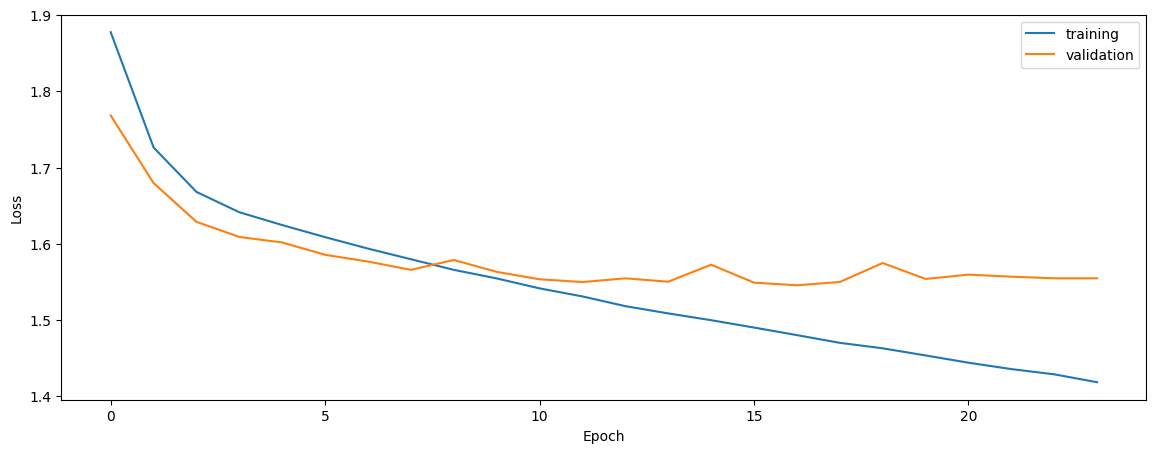

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.4320584290969196
0.4022513481384491
0.3819995824779931


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.44762643547037795
0.4774499784853701
0.40321102918720825


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.4495491072582104
0.47463967433160964
0.41188175099488344


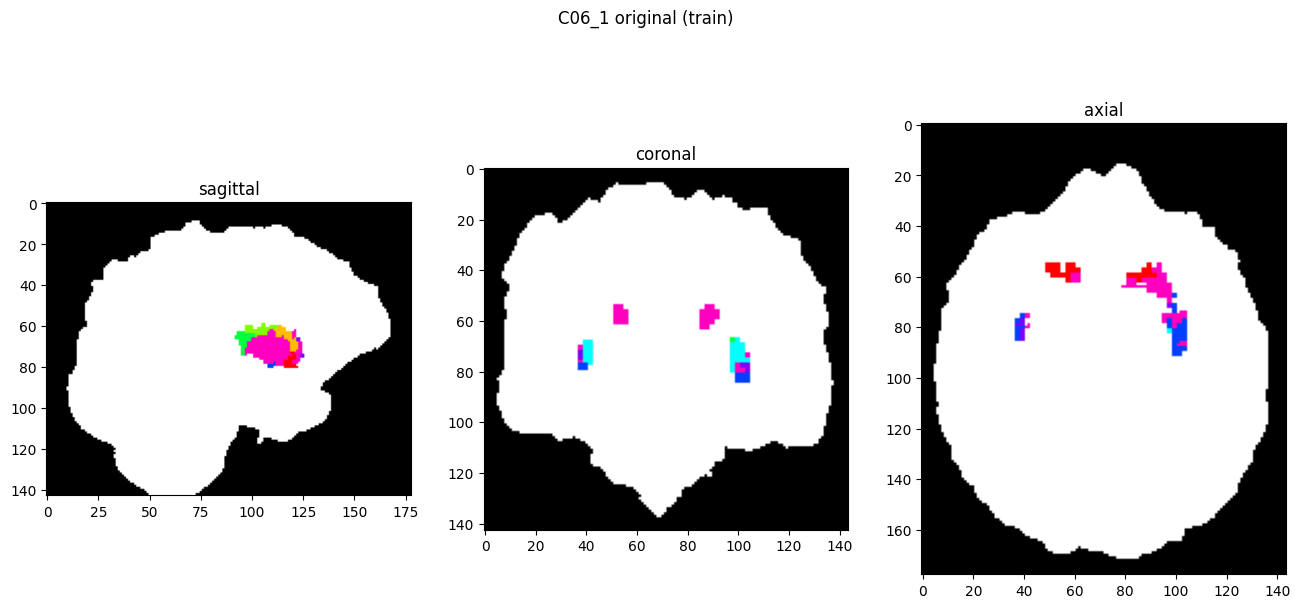

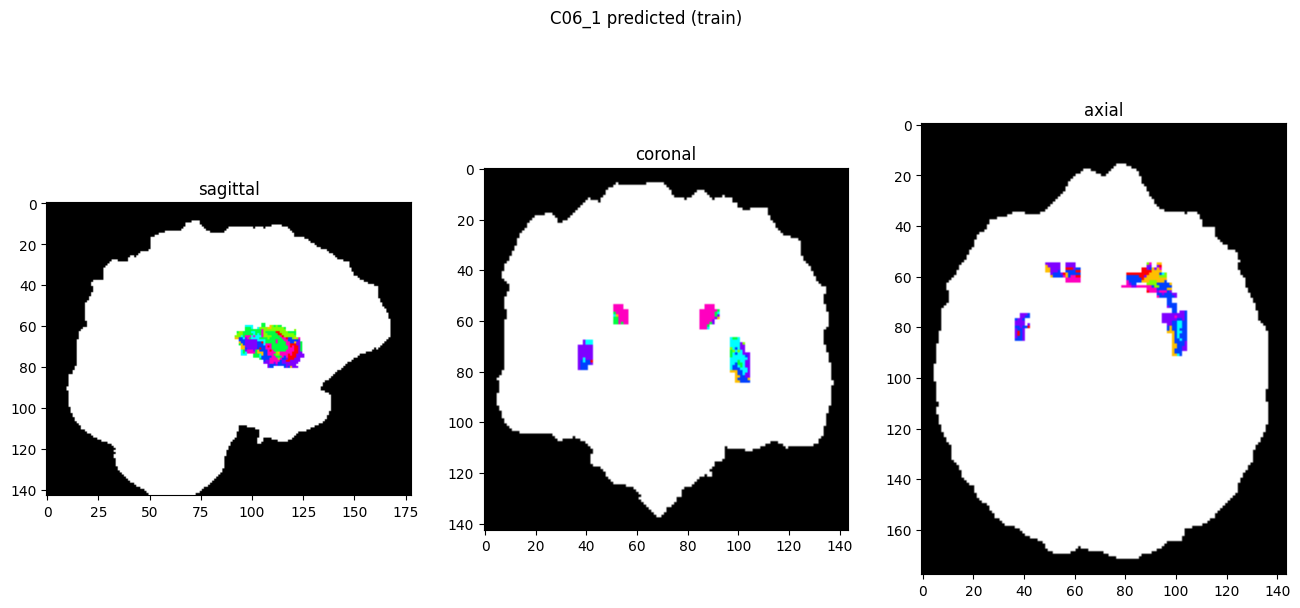

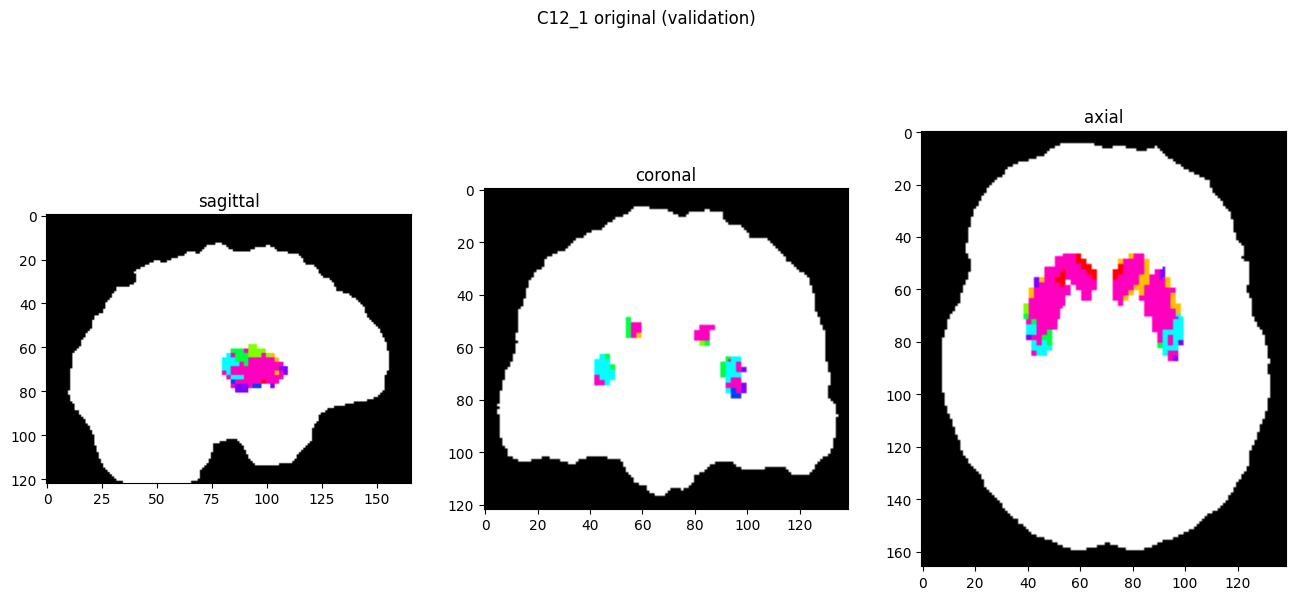

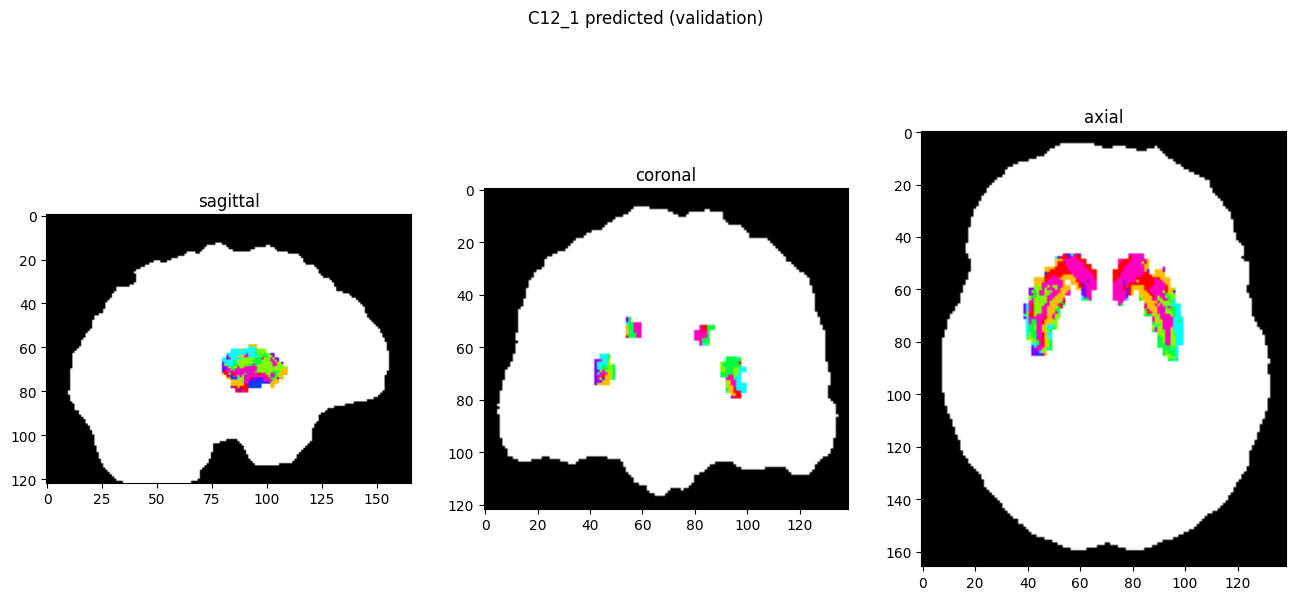

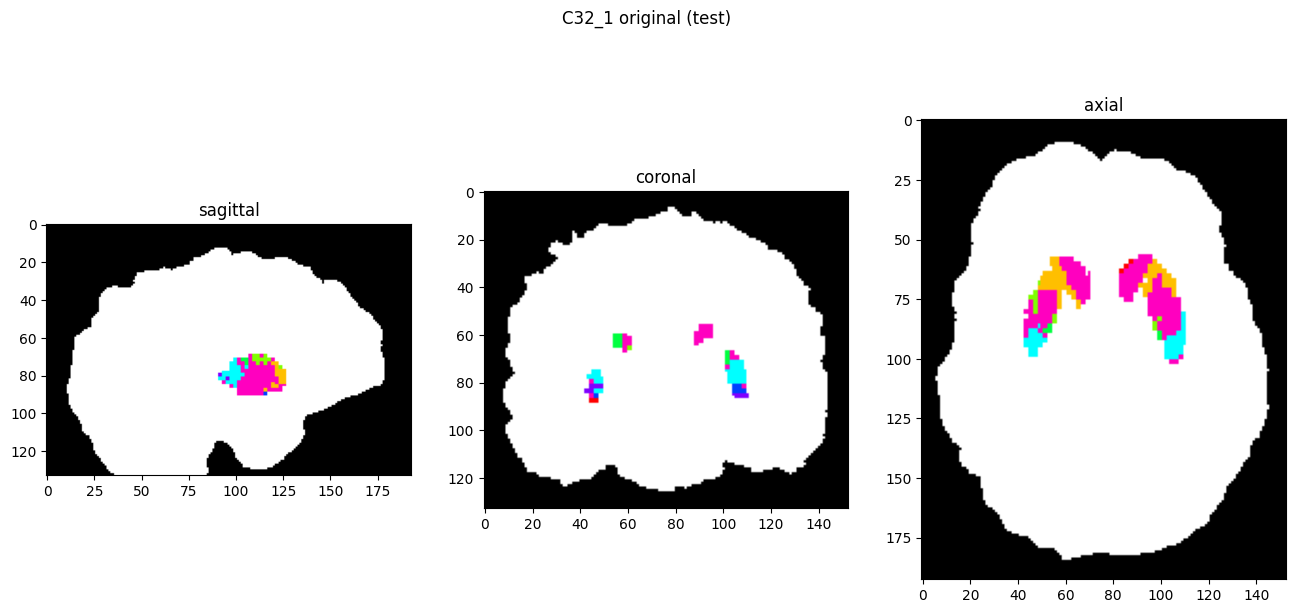

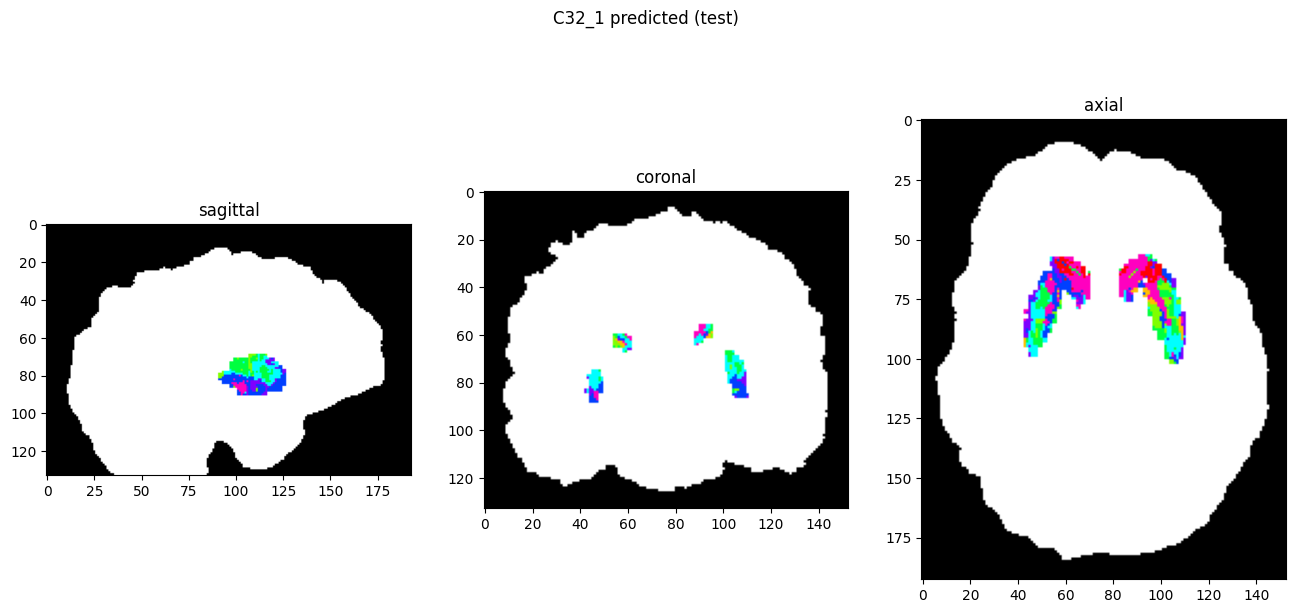

In [10]:
showResults(model, gen, threshold=0)